In [ ]:
!git clone https://github.com/huggingface/transformers.git 

Cloning into 'transformers'...
remote: Enumerating objects: 98581, done.
remote: Counting objects: 100% (369/369), done.
remote: Compressing objects: 100% (218/218), done.
remote: Total 98581 (delta 200), reused 247 (delta 129), pack-reused 98212
Receiving objects: 100% (98581/98581), 92.23 MiB | 12.18 MiB/s, done.
Resolving deltas: 100% (72521/72521), done.


In [ ]:
!mkdir -p megatron/nvidia/megatron-bert-cased-345m/

In [ ]:
!wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/megatron_bert_345m/versions/v0.1_cased/zip -O megatron/nvidia/megatron-bert-cased-345m/checkpoint.zip

--2022-06-20 13:26:44--  https://api.ngc.nvidia.com/v2/models/nvidia/megatron_bert_345m/versions/v0.1_cased/zip
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 54.177.228.152, 54.219.73.126
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|54.177.228.152|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://prod-model-registry-ngc-bucket.s3.us-west-2.amazonaws.com/org/nvidia/models/megatron_bert_345m/versions/v0.1_cased/files.zip?response-content-disposition=attachment%3B%20filename%3D%22files.zip%22&response-content-type=application%2Fzip&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEBUaCXVzLXdlc3QtMSJIMEYCIQDuuKLR00Eu8C4sr2D60nU7AEFJKetCMq%2FroDyi54UamQIhAPBfWHv4imUtG67yYgrlI6DDmYNb%2F%2FNeUHAUbb0V6bAJKtIECC4QBBoMNzg5MzYzMTM1MDI3IgwxOhhs0at8QEu6Ak0qrwS%2Fxke4x1lX4Kl2VG7bUMWyM1SyMXIYa66wqH3Ktg1sMoKqtfTsTBoHOwpXoGhertv5HshSJneLjIai1mUS3qH8OuuTdqlvxP0pmht1uK5bZkOJ0IXVXC6lhAiqs3VsErLt60%2F3vQbSi0MJo12qOE4%2BxRFYsR30Vo4LGWiK2dAEv3T63uz5dySPxAdYk%2BNaWsq69dTnis

In [ ]:
!pip install transformers tokenizers
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
!pip install "ray[tune]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.0 MB/s 
     |████████████████████████████████| 6.6 MB 71.9 MB/s 
     |████████████████████████████████| 596 kB 70.8 MB/s 
     |████████████████████████████████| 86 kB 6.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-qegptuc6
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-qegptuc6
  Running command git submodule update --init --recursive -q
  From https://github.com/Lightning-AI/lightning-tutorials
   * branch            290fb466de1fcc2ac6025f74b56906592911e856 -> FETCH_HEAD
  Installing build

In [ ]:
!python3 transformers/src/transformers/models/megatron_bert/convert_megatron_bert_checkpoint.py megatron/nvidia/megatron-bert-cased-345m/checkpoint.zip

Extracting PyTorch state dictionary from "megatron/nvidia/megatron-bert-cased-345m/checkpoint.zip"
Converting
Saving config
Saving checkpoint to "megatron/nvidia/megatron-bert-cased-345m/pytorch_model.bin"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pytorch_lightning as pl

from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, MegatronBertModel, MegatronBertConfig, BertTokenizer, MegatronBertForSequenceClassification, MegatronBertForMaskedLM
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
from ray import tune
from ray.tune.integration.pytorch_lightning import TuneReportCallback


from typing import Dict, List, Tuple

import logging
import copy
import os
import sys
import gc
import random
from functools import lru_cache
from argparse import Namespace
from packaging import version
from tqdm.autonotebook import tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(21)

In [ ]:
#create a dictionary which associates each string label to an integer value
labels = [ "sadness", "joy", "anger", "fear", "love", "instability", "disgust", "disappointment", "shame", "guilt", "envy", "jealous"]
label2int = dict(zip(labels, list(range(len(labels)))))

In [ ]:
train_path = "/content/drive/MyDrive/Individual Project/Data/Emotion/bt_train.txt"
test_path = "/content/drive/MyDrive/Individual Project/Data/Emotion/bt_test.txt"
val_path = "/content/drive/MyDrive/Individual Project/Data/Emotion/bt_val.txt"

In [ ]:

model = MegatronBertModel.from_pretrained("/content/megatron/nvidia/megatron-bert-cased-345m")

Some weights of the model checkpoint at /content/megatron/nvidia/megatron-bert-cased-345m were not used when initializing MegatronBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing MegatronBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MegatronBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class EmoClassificationModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=1024, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            nn.Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        
        return self.classifier(hidden_states[0][:, 0, :])

In [ ]:
class CollateFn:
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained("nvidia/megatron-bert-cased-345m")
    def __call__(self, batch):
        inputs = list(x[0] for x in batch)
        encoded = self.tokenizer(inputs, padding=True)
        sequences_padded = torch.tensor([ids for ids in encoded['input_ids']])
        attention_masks_padded = torch.tensor([masks for masks in encoded['attention_mask']])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels

In [ ]:
class EmoDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "class"
        self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column],
                               engine="python")

    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

    def __len__(self):
        return self.data.shape[0]

In [ ]:
ds = EmoDataset(train_path)
ds[20]

('i have lost a significant amount of money and i am mad at myself i feel like punching myself',
 2)

In [ ]:
class TrainingModule(pl.LightningModule):
    def __init__(self, hparams, config):
        super().__init__()
        self.model = EmoClassificationModel(MegatronBertModel.from_pretrained("/content/megatron/nvidia/megatron-bert-cased-345m"), len(labels))
        self.loss = nn.CrossEntropyLoss() #cross entropy loss since this is multi-class classification
        self.save_hyperparameters(hparams)
        self.lr = config['lr']
        self.batch_size = config['batch_size']
        self.epochs = config['epochs']
        self.accumulate_grad_batches = config['accumulate_grad_batches']

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}
        self.log(f"ptl/{loss_key}", loss)

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.batch_size,
                    num_workers=4,
                    shuffle=shuffle,
                    collate_fn=CollateFn()
        )
        
    def total_steps(self):
        return len(self.train_dataloader()) // self.accumulate_grad_batches * self.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.lr) #we use AdamW as this usually performs well
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

    def save_model(self):
        torch.save(self.model.state_dict(), '/content/Megatron_BERT_finetuned.pt')

In [ ]:
config = {
    "batch_size": tune.grid_search([4, 8, 16, 32]),
    "lr": tune.loguniform(4e-4, 1e-6),
    "epochs": tune.grid_search([6, 10, 16, 20]),
    "accumulate_grad_batches": tune.grid_search([1,2,4,8])
}

In [ ]:
#chosen hyperparams:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    warmup_steps=100,
    seed=21
)
module = TrainingModule(hparams, config)

Some weights of the model checkpoint at /content/megatron/nvidia/megatron-bert-cased-345m were not used when initializing MegatronBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing MegatronBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MegatronBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#train
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:430: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | EmoClassificationModel | 334 M 
1 | loss  | Cr

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:648: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
trainable = tune.with_parameters(
    train_model,
    num_gpus = 1,
    hparams=hparams,
)

In [ ]:
analysis = tune.run(
    trainable,
    resources_per_trial = {
        "cpu": 4,
        "gpu": 1
    },
    metric="loss",
    mode="min",
    num_samples=10,
    config=config
)

print(analysis.best_config)


(train_model pid=4467) Some weights of the model checkpoint at /content/megatron/nvidia/megatron-bert-cased-345m were not used when initializing MegatronBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
(train_model pid=4467) - This IS expected if you are initializing MegatronBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(train_model pid=4467) - This IS NOT expected if you are initializing MegatronBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(train_model pid=4467) /usr/lo

(train_model pid=4467) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(train_model pid=4467) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train_model pid=4467)   FutureWarning,


(train_model pid=4467) 
(train_model pid=4467)   | Name  | Type                   | Params
(train_model pid=4467) -------------------------------------------------
(train_model pid=4467) 0 | model | EmoClassificationModel | 334 M 
(train_model pid=4467) 1 | loss  | CrossEntropyLoss       | 0     
(train_model pid=4467) -------------------------------------------------
(train_model pid=4467) 334 M     Trainable params
(train_model pid=4467) 0         Non-trainable params
(train_model pid=4467) 334 M     Total params
(train_model pid=4467) 1,338.810 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
                                                                           
Epoch 0:   0%|          | 0/654 [00:00<?, ?it/s] 


Epoch 0:   3%|▎         | 20/654 [00:02<01:28,  7.13it/s, loss=2.47, v_num=0]


Epoch 0:  12%|█▏        | 80/654 [00:10<01:14,  7.73it/s, loss=2.12, v_num=0]


Epoch 0:  15%|█▌        | 100/654 [00:12<01:10,  7.81it/s, loss=1.82, v_num=0]


Epoch 0:  24%|██▍       | 160/654 [00:20<01:02,  7.86it/s, loss=1.14, v_num=0]


Epoch 0:  28%|██▊       | 180/654 [00:23<01:00,  7.82it/s, loss=0.826, v_num=0]


Epoch 0:  34%|███▎      | 220/654 [00:28<00:55,  7.83it/s, loss=2.51, v_num=0]


Epoch 0:  40%|███▉      | 260/654 [00:33<00:50,  7.83it/s, loss=2.52, v_num=0]


Epoch 0:  46%|████▌     | 300/654 [00:38<00:45,  7.82it/s, loss=2.53, v_num=0]


Epoch 0:  52%|█████▏    | 340/654 [00:43<00:40,  7.83it/s, loss=2.49, v_num=0]


Epoch 0:  58%|█████▊    | 380/654 [00:48<00:34,  7.84it/s, loss=2.53, v_num=0]


Epoch 0:  64%|██████▍   | 420/654 [00:53<00:29,  7.87it/s, loss=2.53, v_num=0]


Epoch 0:  70%|███████   | 460/654 [00:58<00:24,  7.87it/s, loss=2.53, v_num=0]


Epoch 0:  76%|███████▋  | 500/654 [01:03<00:19,  7.87it/s, loss=2.54, v_num=0]


Epoch 0:  83%|████████▎ | 540/654 [01:08<00:14,  7.87it/s, loss=2.54, v_num=0]


Epoch 0:  89%|████████▊ | 580/654 [01:13<00:09,  7.87it/s, loss=2.5, v_num=0]
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Epoch 0:  92%|█████████▏| 600/654 [01:14<00:06,  8.03it/s, loss=2.5, v_num=0]
(train_model pid=4467) 
Validation DataLoader 0:  55%|█████▍    | 40/73 [00:00<00:00, 41.09it/s]


Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 40.18it/s]
(train_model pid=4467) 
Epoch 0: 100%|██████████| 654/654 [01:16<00:00,  8.60it/s, loss=2.5, v_num=0]
Result for train_model_7a18d_00000:
  date: 2022-06-20_14-46-04
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 1
  loss: 2.4894447326660156
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 95.72144293785095
  time_this_iter_s: 95.72144293785095
  time_total_s: 95.72144293785095
  timestamp: 1655736364
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
Epoch 0: 100%|██████████| 654/654 [01:16<00:00,  8.60it/s, loss=2.5, v_num=0]


(train_model pid=4467) tcmalloc: large alloc 1110278144 bytes == 0x1803f4000 @  0x7fcc78e04615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fca7a679e24 0x7fca7a718484 0x7fca7a6eb4a0 0x7fca00722ea5 0x7fca0071e604 0x7fca00726185 0x7fca7a6eb9f2 0x7fca7a3c73f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=4467) tcmalloc: large alloc 1387847680 bytes == 0x120f3a000 @  0x7fcc78e04615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fca7a679e24 0x7fca7a718484 0x7fca7a6eb4a0 0x7fca00722ea5 0x7fca0071e604 0x7fca00726185 0x7fca7a6eb9f2 0x7fca7a3c73f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=4467) tcmalloc: large alloc 1734811648 bytes == 0x173ac8000 @  0x7fcc78e04615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fca7a679e24 0x7fca7a718484 0x7fca7a6eb4a

(train_model pid=4467) tcmalloc: large alloc 2168520704 bytes == 0x7fc6a0bf0000 @  0x7fcc78e04615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fca7a679e24 0x7fca7a718484 0x7fca7a6eb4a0 0x7fca00722ea5 0x7fca0071e604 0x7fca00726185 0x7fca7a6eb9f2 0x7fca7a3c73f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=4467) tcmalloc: large alloc 2710650880 bytes == 0x120f3a000 @  0x7fcc78e04615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fca7a679e24 0x7fca7a718484 0x7fca7a6eb4a0 0x7fca00722ea5 0x7fca0071e604 0x7fca00726185 0x7fca7a6eb9f2 0x7fca7a3c73f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=4467) tcmalloc: large alloc 3388317696 bytes == 0x7fc5d6c96000 @  0x7fcc78e04615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fca7a679e24 0x7fca7a718484 0x7fca7

(train_model pid=4467) tcmalloc: large alloc 4235403264 bytes == 0x7fc4d9d64000 @  0x7fcc78e04615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fca7a679e24 0x7fca7a718484 0x7fca7a6eb4a0 0x7fca00722ea5 0x7fca0071e604 0x7fca00726185 0x7fca7a6eb9f2 0x7fca7a3c73f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 0: 100%|██████████| 654/654 [01:32<00:00,  7.08it/s, loss=2.5, v_num=0]


Epoch 1:   0%|          | 0/654 [00:00<?, ?it/s, loss=2.5, v_num=0]


(train_model pid=4467) E0620 14:46:35.378761564    4498 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


Epoch 1:   3%|▎         | 20/654 [00:03<01:42,  6.18it/s, loss=2.49, v_num=0]


Epoch 1:   9%|▉         | 60/654 [00:08<01:23,  7.11it/s, loss=2.52, v_num=0]


Epoch 1:  15%|█▌        | 100/654 [00:13<01:15,  7.34it/s, loss=2.52, v_num=0]


Epoch 1:  21%|██▏       | 140/654 [00:18<01:09,  7.45it/s, loss=2.47, v_num=0]


Epoch 1:  28%|██▊       | 180/654 [00:24<01:03,  7.47it/s, loss=2.64, v_num=0]


Epoch 1:  34%|███▎      | 220/654 [00:29<00:57,  7.50it/s, loss=2.04, v_num=0]


Epoch 1:  40%|███▉      | 260/654 [00:34<00:52,  7.54it/s, loss=2.05, v_num=0]


Epoch 1:  46%|████▌     | 300/654 [00:39<00:46,  7.56it/s, loss=1.99, v_num=0]


Epoch 1:  52%|█████▏    | 340/654 [00:44<00:41,  7.59it/s, loss=1.71, v_num=0]


Epoch 1:  58%|█████▊    | 380/654 [00:50<00:36,  7.59it/s, loss=1.43, v_num=0]


Epoch 1:  64%|██████▍   | 420/654 [00:55<00:30,  7.61it/s, loss=1.16, v_num=0]


Epoch 1:  70%|███████   | 460/654 [01:00<00:25,  7.61it/s, loss=1.35, v_num=0]


Epoch 1:  76%|███████▋  | 500/654 [01:05<00:20,  7.62it/s, loss=1.53, v_num=0]


Epoch 1:  83%|████████▎ | 540/654 [01:10<00:14,  7.64it/s, loss=1.44, v_num=0]


Epoch 1:  86%|████████▌ | 560/654 [01:13<00:12,  7.65it/s, loss=1.31, v_num=0]


Epoch 1:  89%|████████▊ | 580/654 [01:15<00:09,  7.65it/s, loss=1.3, v_num=0] 
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 38.59it/s]
Result for train_model_7a18d_00000:
  date: 2022-06-20_14-47-52
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 2
  loss: 1.3322299718856812
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 203.87333011627197
  time_this_iter_s: 108.15188717842102
  time_total_s: 203.87333011627197
  timestamp: 1655736472
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
(train_model pid=4467) 
Epoch 1: 100%|██████████| 654/654 [01:18<00:00,  8.32it/s, loss=1.33, v_num=0]


(train_model pid=4467) tcmalloc: large alloc 2710650880 bytes == 0x120f3a000 @  0x7fcc78e04615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fca7a679e24 0x7fca7a718484 0x7fca7a6eb4a0 0x7fca00722ea5 0x7fca0071e604 0x7fca00726185 0x7fca7a6eb9f2 0x7fca7a3c73f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=4467) tcmalloc: large alloc 3388317696 bytes == 0x7fc4d9d64000 @  0x7fcc78e04615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fca7a679e24 0x7fca7a718484 0x7fca7a6eb4a0 0x7fca00722ea5 0x7fca0071e604 0x7fca00726185 0x7fca7a6eb9f2 0x7fca7a3c73f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


(train_model pid=4467) tcmalloc: large alloc 4235403264 bytes == 0x7fc5d6c96000 @  0x7fcc78e04615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fca7a679e24 0x7fca7a718484 0x7fca7a6eb4a0 0x7fca00722ea5 0x7fca0071e604 0x7fca00726185 0x7fca7a6eb9f2 0x7fca7a3c73f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 1: 100%|██████████| 654/654 [01:37<00:00,  6.73it/s, loss=1.33, v_num=0]


Epoch 2:   0%|          | 0/654 [00:00<?, ?it/s, loss=1.33, v_num=0]


Epoch 2:   3%|▎         | 20/654 [00:03<01:55,  5.47it/s, loss=1.05, v_num=0]


Epoch 2:   9%|▉         | 60/654 [00:08<01:27,  6.78it/s, loss=1.38, v_num=0]


Epoch 2:  15%|█▌        | 100/654 [00:13<01:17,  7.18it/s, loss=1.08, v_num=0]


Epoch 2:  21%|██▏       | 140/654 [00:19<01:09,  7.36it/s, loss=1.02, v_num=0] 


Epoch 2:  28%|██▊       | 180/654 [00:24<01:03,  7.42it/s, loss=0.9, v_num=0] 


Epoch 2:  34%|███▎      | 220/654 [00:29<00:58,  7.48it/s, loss=0.807, v_num=0]


Epoch 2:  40%|███▉      | 260/654 [00:34<00:52,  7.51it/s, loss=1.01, v_num=0]


Epoch 2:  46%|████▌     | 300/654 [00:39<00:47,  7.51it/s, loss=1.01, v_num=0] 


Epoch 2:  49%|████▉     | 320/654 [00:42<00:44,  7.52it/s, loss=1.14, v_num=0]


Epoch 2:  55%|█████▌    | 360/654 [00:48<00:39,  7.47it/s, loss=0.909, v_num=0]


Epoch 2:  61%|██████    | 400/654 [00:53<00:33,  7.50it/s, loss=1.02, v_num=0]


Epoch 2:  67%|██████▋   | 440/654 [00:58<00:28,  7.52it/s, loss=0.771, v_num=0]


Epoch 2:  73%|███████▎  | 480/654 [01:03<00:23,  7.54it/s, loss=0.92, v_num=0] 


Epoch 2:  80%|███████▉  | 520/654 [01:08<00:17,  7.55it/s, loss=0.826, v_num=0]


Epoch 2:  86%|████████▌ | 560/654 [01:14<00:12,  7.55it/s, loss=1.09, v_num=0] 


Epoch 2:  89%|████████▊ | 580/654 [01:16<00:09,  7.55it/s, loss=1.07, v_num=0]
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 38.35it/s]
Result for train_model_7a18d_00000:
  date: 2022-06-20_14-49-41
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 3
  loss: 0.9931011199951172
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 313.3794059753418
  time_this_iter_s: 109.50607585906982
  time_total_s: 313.3794059753418
  timestamp: 1655736581
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
(train_model pid=4467) 
Epoch 2: 100%|██████████| 654/654 [01:19<00:00,  8.22it/s, loss=1.03, v_num=0]


(train_model pid=4467) tcmalloc: large alloc 4235403264 bytes == 0x7fc5d6c96000 @  0x7fcc78e04615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fca7a679e24 0x7fca7a718484 0x7fca7a6eb4a0 0x7fca00722ea5 0x7fca0071e604 0x7fca00726185 0x7fca7a6eb9f2 0x7fca7a3c73f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 2: 100%|██████████| 654/654 [01:38<00:00,  6.61it/s, loss=1.03, v_num=0]


Epoch 3:   3%|▎         | 20/654 [00:03<01:45,  6.01it/s, loss=0.895, v_num=0]


Epoch 3:   9%|▉         | 60/654 [00:08<01:24,  7.07it/s, loss=0.619, v_num=0]


Epoch 3:  15%|█▌        | 100/654 [00:13<01:15,  7.34it/s, loss=0.624, v_num=0]


Epoch 3:  21%|██▏       | 140/654 [00:18<01:09,  7.42it/s, loss=0.692, v_num=0]


Epoch 3:  28%|██▊       | 180/654 [00:24<01:03,  7.49it/s, loss=0.538, v_num=0]


Epoch 3:  34%|███▎      | 220/654 [00:29<00:57,  7.53it/s, loss=0.656, v_num=0]


Epoch 3:  40%|███▉      | 260/654 [00:34<00:52,  7.54it/s, loss=0.603, v_num=0]


Epoch 3:  46%|████▌     | 300/654 [00:39<00:47,  7.52it/s, loss=0.665, v_num=0]


Epoch 3:  49%|████▉     | 320/654 [00:42<00:44,  7.53it/s, loss=0.711, v_num=0]


Epoch 3:  55%|█████▌    | 360/654 [00:47<00:38,  7.54it/s, loss=0.721, v_num=0]


Epoch 3:  61%|██████    | 400/654 [00:52<00:33,  7.55it/s, loss=0.552, v_num=0]


Epoch 3:  67%|██████▋   | 440/654 [00:58<00:28,  7.56it/s, loss=0.929, v_num=0]


Epoch 3:  73%|███████▎  | 480/654 [01:03<00:23,  7.56it/s, loss=0.632, v_num=0]


Epoch 3:  80%|███████▉  | 520/654 [01:08<00:17,  7.57it/s, loss=0.563, v_num=0]


Epoch 3:  86%|████████▌ | 560/654 [01:14<00:12,  7.57it/s, loss=0.593, v_num=0]


Epoch 3:  89%|████████▊ | 580/654 [01:16<00:09,  7.57it/s, loss=0.462, v_num=0]
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.92it/s]
Result for train_model_7a18d_00000:
  date: 2022-06-20_14-51-31
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 4
  loss: 0.9016532301902771
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 422.88363313674927
  time_this_iter_s: 109.50422716140747
  time_total_s: 422.88363313674927
  timestamp: 1655736691
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
(train_model pid=4467) 
Epoch 3: 100%|██████████| 654/654 [01:19<00:00,  8.23it/s, loss=0.461, v_num=0]


Epoch 3: 100%|██████████| 654/654 [01:29<00:00,  7.32it/s, loss=0.461, v_num=0]


(train_model pid=4467) tcmalloc: large alloc 4235403264 bytes == 0x7fc5d6c96000 @  0x7fcc78e04615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fca7a679e24 0x7fca7a718484 0x7fca7a6eb4a0 0x7fca00722ea5 0x7fca0071e604 0x7fca00726185 0x7fca7a6eb9f2 0x7fca7a3c73f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 4:   3%|▎         | 20/654 [00:03<01:47,  5.90it/s, loss=0.389, v_num=0]


Epoch 4:   9%|▉         | 60/654 [00:08<01:23,  7.09it/s, loss=0.357, v_num=0]


Epoch 4:  15%|█▌        | 100/654 [00:13<01:16,  7.28it/s, loss=0.582, v_num=0]


Epoch 4:  21%|██▏       | 140/654 [00:18<01:09,  7.38it/s, loss=0.354, v_num=0]


Epoch 4:  28%|██▊       | 180/654 [00:24<01:03,  7.48it/s, loss=0.473, v_num=0]


Epoch 4:  34%|███▎      | 220/654 [00:29<00:57,  7.54it/s, loss=0.368, v_num=0]


Epoch 4:  40%|███▉      | 260/654 [00:34<00:52,  7.56it/s, loss=0.479, v_num=0]


Epoch 4:  46%|████▌     | 300/654 [00:39<00:46,  7.59it/s, loss=0.437, v_num=0]


Epoch 4:  52%|█████▏    | 340/654 [00:44<00:41,  7.57it/s, loss=0.266, v_num=0]


Epoch 4:  55%|█████▌    | 360/654 [00:47<00:38,  7.57it/s, loss=0.554, v_num=0]


Epoch 4:  61%|██████    | 400/654 [00:52<00:33,  7.57it/s, loss=0.662, v_num=0]


Epoch 4:  67%|██████▋   | 440/654 [00:58<00:28,  7.58it/s, loss=0.435, v_num=0]


Epoch 4:  73%|███████▎  | 480/654 [01:03<00:22,  7.57it/s, loss=0.363, v_num=0]


Epoch 4:  80%|███████▉  | 520/654 [01:08<00:17,  7.58it/s, loss=0.486, v_num=0]


Epoch 4:  86%|████████▌ | 560/654 [01:13<00:12,  7.59it/s, loss=0.611, v_num=0]


Epoch 4:  89%|████████▊ | 580/654 [01:16<00:09,  7.58it/s, loss=0.458, v_num=0]
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Epoch 4:  92%|█████████▏| 600/654 [01:17<00:06,  7.72it/s, loss=0.458, v_num=0]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.66it/s]
Result for train_model_7a18d_00000:
  date: 2022-06-20_14-53-20
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 5
  loss: 0.939342737197876
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 532.3393199443817
  time_this_iter_s: 109.45568680763245
  time_total_s: 532.3393199443817
  timestamp: 1655736800
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
(train_model pid=4467) 
Epoch 4: 100%|██████████| 654/654 [01:19<00:00,  8.25it/s, loss=0.428, v_num=0]


Epoch 4: 100%|██████████| 654/654 [01:33<00:00,  7.02it/s, loss=0.428, v_num=0]


Epoch 5:   0%|          | 0/654 [00:00<?, ?it/s, loss=0.428, v_num=0]


Epoch 5:   3%|▎         | 20/654 [00:03<01:50,  5.72it/s, loss=0.218, v_num=0]


Epoch 5:   9%|▉         | 60/654 [00:08<01:25,  6.97it/s, loss=0.176, v_num=0]


Epoch 5:  15%|█▌        | 100/654 [00:13<01:16,  7.26it/s, loss=0.283, v_num=0]


Epoch 5:  21%|██▏       | 140/654 [00:18<01:09,  7.39it/s, loss=0.238, v_num=0]


Epoch 5:  28%|██▊       | 180/654 [00:24<01:03,  7.44it/s, loss=0.445, v_num=0]


Epoch 5:  34%|███▎      | 220/654 [00:29<00:58,  7.46it/s, loss=0.251, v_num=0]


Epoch 5:  40%|███▉      | 260/654 [00:34<00:52,  7.52it/s, loss=0.362, v_num=0]


Epoch 5:  46%|████▌     | 300/654 [00:39<00:47,  7.53it/s, loss=0.693, v_num=0]


Epoch 5:  52%|█████▏    | 340/654 [00:44<00:41,  7.57it/s, loss=0.471, v_num=0]


Epoch 5:  58%|█████▊    | 380/654 [00:50<00:36,  7.59it/s, loss=0.407, v_num=0]


Epoch 5:  61%|██████    | 400/654 [00:52<00:33,  7.57it/s, loss=0.291, v_num=0]


Epoch 5:  67%|██████▋   | 440/654 [00:57<00:28,  7.60it/s, loss=0.619, v_num=0]


Epoch 5:  73%|███████▎  | 480/654 [01:03<00:22,  7.59it/s, loss=0.335, v_num=0]


Epoch 5:  80%|███████▉  | 520/654 [01:08<00:17,  7.60it/s, loss=0.28, v_num=0] 


Epoch 5:  86%|████████▌ | 560/654 [01:13<00:12,  7.59it/s, loss=0.246, v_num=0]


Epoch 5:  89%|████████▊ | 580/654 [01:16<00:09,  7.58it/s, loss=0.384, v_num=0]
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Epoch 5:  92%|█████████▏| 600/654 [01:17<00:06,  7.72it/s, loss=0.384, v_num=0]
(train_model pid=4467) 
Epoch 5:  95%|█████████▍| 620/654 [01:18<00:04,  7.92it/s, loss=0.384, v_num=0]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.71it/s]
(train_model pid=4467) 
Epoch 5: 100%|██████████| 654/654 [01:19<00:00,  8.26it/s, loss=0.384, v_num=0]
Result for train_model_7a18d_00000:
  date: 2022-06-20_14-55-10
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 6
  loss: 0.8013478517532349
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 641.8590211868286
  time_this_iter_s: 109.5197012424469
  time_total_s: 641.8590211868286
  timestamp: 1655736910
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 7a18d_00000

Epoch 5: 100%|██████████| 654/654 [01:34<00:00,  6.96it/s, loss=0.349, v_num=0]


Epoch 6:   3%|▎         | 20/654 [00:03<01:45,  6.01it/s, loss=0.257, v_num=0]


Epoch 6:   9%|▉         | 60/654 [00:08<01:25,  6.98it/s, loss=0.214, v_num=0]


Epoch 6:  15%|█▌        | 100/654 [00:13<01:17,  7.18it/s, loss=0.355, v_num=0]


Epoch 6:  21%|██▏       | 140/654 [00:19<01:10,  7.32it/s, loss=0.267, v_num=0]


Epoch 6:  28%|██▊       | 180/654 [00:24<01:04,  7.40it/s, loss=0.393, v_num=0] 


Epoch 6:  34%|███▎      | 220/654 [00:29<00:58,  7.48it/s, loss=0.202, v_num=0]


Epoch 6:  40%|███▉      | 260/654 [00:34<00:52,  7.49it/s, loss=0.173, v_num=0]


Epoch 6:  43%|████▎     | 280/654 [00:37<00:49,  7.49it/s, loss=0.309, v_num=0]


Epoch 6:  49%|████▉     | 320/654 [00:42<00:44,  7.47it/s, loss=0.285, v_num=0]


Epoch 6:  55%|█████▌    | 360/654 [00:47<00:39,  7.50it/s, loss=0.368, v_num=0]


Epoch 6:  61%|██████    | 400/654 [00:53<00:33,  7.51it/s, loss=0.229, v_num=0]


Epoch 6:  67%|██████▋   | 440/654 [00:58<00:28,  7.52it/s, loss=0.188, v_num=0]


Epoch 6:  73%|███████▎  | 480/654 [01:03<00:23,  7.53it/s, loss=0.216, v_num=0]


Epoch 6:  80%|███████▉  | 520/654 [01:08<00:17,  7.56it/s, loss=0.248, v_num=0]


Epoch 6:  86%|████████▌ | 560/654 [01:14<00:12,  7.55it/s, loss=0.271, v_num=0]


Epoch 6:  89%|████████▊ | 580/654 [01:16<00:09,  7.55it/s, loss=0.346, v_num=0]
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Epoch 6:  92%|█████████▏| 600/654 [01:18<00:07,  7.68it/s, loss=0.346, v_num=0]
(train_model pid=4467) 
Epoch 6:  95%|█████████▍| 620/654 [01:18<00:04,  7.89it/s, loss=0.346, v_num=0]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.61it/s]
Result for train_model_7a18d_00000:
  date: 2022-06-20_14-57-00
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 7
  loss: 0.8988053798675537
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 751.8026821613312
  time_this_iter_s: 109.94366097450256
  time_total_s: 751.8026821613312
  timestamp: 1655737020
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
(train_model pid=4467) 
Epoch 6: 100%|██████████| 654/654 [01:

Epoch 6: 100%|██████████| 654/654 [01:34<00:00,  6.92it/s, loss=0.381, v_num=0]


Epoch 7:   3%|▎         | 20/654 [00:03<01:49,  5.81it/s, loss=0.0886, v_num=0]


Epoch 7:   9%|▉         | 60/654 [00:08<01:26,  6.88it/s, loss=0.0931, v_num=0]


Epoch 7:  15%|█▌        | 100/654 [00:13<01:16,  7.22it/s, loss=0.226, v_num=0]


Epoch 7:  21%|██▏       | 140/654 [00:19<01:09,  7.36it/s, loss=0.073, v_num=0]


Epoch 7:  28%|██▊       | 180/654 [00:24<01:03,  7.46it/s, loss=0.0886, v_num=0]


Epoch 7:  34%|███▎      | 220/654 [00:29<00:57,  7.51it/s, loss=0.236, v_num=0]


Epoch 7:  37%|███▋      | 240/654 [00:32<00:55,  7.49it/s, loss=0.125, v_num=0]


Epoch 7:  43%|████▎     | 280/654 [00:37<00:49,  7.49it/s, loss=0.0381, v_num=0]


Epoch 7:  49%|████▉     | 320/654 [00:42<00:44,  7.51it/s, loss=0.128, v_num=0]


Epoch 7:  55%|█████▌    | 360/654 [00:47<00:39,  7.52it/s, loss=0.177, v_num=0]


Epoch 7:  61%|██████    | 400/654 [00:53<00:33,  7.53it/s, loss=0.268, v_num=0]


Epoch 7:  67%|██████▋   | 440/654 [00:58<00:28,  7.55it/s, loss=0.181, v_num=0]


Epoch 7:  73%|███████▎  | 480/654 [01:03<00:23,  7.55it/s, loss=0.197, v_num=0]


Epoch 7:  80%|███████▉  | 520/654 [01:08<00:17,  7.56it/s, loss=0.259, v_num=0] 


Epoch 7:  86%|████████▌ | 560/654 [01:14<00:12,  7.56it/s, loss=0.196, v_num=0]


Epoch 7:  89%|████████▊ | 580/654 [01:16<00:09,  7.57it/s, loss=0.0911, v_num=0]
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Epoch 7:  98%|█████████▊| 640/654 [01:18<00:01,  8.10it/s, loss=0.0911, v_num=0]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.61it/s]
Result for train_model_7a18d_00000:
  date: 2022-06-20_14-58-50
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 8
  loss: 0.9956014752388
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 861.7969627380371
  time_this_iter_s: 109.99428057670593
  time_total_s: 861.7969627380371
  timestamp: 1655737130
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
(train_model pid=4467) 
Epoch 7: 100%|██████████| 654/654 [01:19<00:00,  8.23it/s, loss=0.111, v_num=0]


Epoch 7: 100%|██████████| 654/654 [01:34<00:00,  6.93it/s, loss=0.111, v_num=0]


Epoch 8:   0%|          | 0/654 [00:00<?, ?it/s, loss=0.111, v_num=0]


Epoch 8:   3%|▎         | 20/654 [00:03<01:51,  5.67it/s, loss=0.166, v_num=0]


Epoch 8:   9%|▉         | 60/654 [00:08<01:26,  6.88it/s, loss=0.164, v_num=0] 


Epoch 8:  15%|█▌        | 100/654 [00:13<01:16,  7.22it/s, loss=0.0269, v_num=0]


Epoch 8:  21%|██▏       | 140/654 [00:19<01:10,  7.34it/s, loss=0.158, v_num=0]


Epoch 8:  28%|██▊       | 180/654 [00:24<01:03,  7.45it/s, loss=0.252, v_num=0]


Epoch 8:  34%|███▎      | 220/654 [00:29<00:58,  7.45it/s, loss=0.0692, v_num=0]


Epoch 8:  40%|███▉      | 260/654 [00:34<00:52,  7.49it/s, loss=0.236, v_num=0]


Epoch 8:  46%|████▌     | 300/654 [00:39<00:47,  7.53it/s, loss=0.0886, v_num=0]


Epoch 8:  49%|████▉     | 320/654 [00:42<00:44,  7.53it/s, loss=0.181, v_num=0] 


Epoch 8:  55%|█████▌    | 360/654 [00:47<00:39,  7.53it/s, loss=0.124, v_num=0]


Epoch 8:  61%|██████    | 400/654 [00:53<00:33,  7.54it/s, loss=0.143, v_num=0]


Epoch 8:  67%|██████▋   | 440/654 [00:58<00:28,  7.54it/s, loss=0.107, v_num=0]


Epoch 8:  73%|███████▎  | 480/654 [01:03<00:23,  7.55it/s, loss=0.186, v_num=0]


Epoch 8:  80%|███████▉  | 520/654 [01:08<00:17,  7.55it/s, loss=0.122, v_num=0]


Epoch 8:  86%|████████▌ | 560/654 [01:14<00:12,  7.53it/s, loss=0.107, v_num=0] 


Epoch 8:  89%|████████▊ | 580/654 [01:16<00:09,  7.54it/s, loss=0.136, v_num=0]
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Epoch 8:  92%|█████████▏| 600/654 [01:18<00:07,  7.67it/s, loss=0.136, v_num=0]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.51it/s]
Result for train_model_7a18d_00000:
  date: 2022-06-20_15-00-40
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 9
  loss: 0.9919767379760742
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 971.7854859828949
  time_this_iter_s: 109.98852324485779
  time_total_s: 971.7854859828949
  timestamp: 1655737240
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
(train_model pid=4467) 
Epoch 8: 100%|██████████| 654/654 [01:19<00:00,  8.20it/s, loss=0.138, v_num=0]


Epoch 8: 100%|██████████| 654/654 [01:34<00:00,  6.90it/s, loss=0.138, v_num=0]


Epoch 9:   3%|▎         | 20/654 [00:03<01:51,  5.68it/s, loss=0.0766, v_num=0]


Epoch 9:   9%|▉         | 60/654 [00:08<01:25,  6.94it/s, loss=0.0636, v_num=0]


Epoch 9:  15%|█▌        | 100/654 [00:13<01:17,  7.18it/s, loss=0.0985, v_num=0]


Epoch 9:  21%|██▏       | 140/654 [00:19<01:10,  7.33it/s, loss=0.153, v_num=0] 


Epoch 9:  28%|██▊       | 180/654 [00:24<01:03,  7.44it/s, loss=0.0826, v_num=0]


Epoch 9:  34%|███▎      | 220/654 [00:29<00:58,  7.48it/s, loss=0.0254, v_num=0]


Epoch 9:  40%|███▉      | 260/654 [00:34<00:52,  7.51it/s, loss=0.237, v_num=0]


Epoch 9:  43%|████▎     | 280/654 [00:37<00:49,  7.53it/s, loss=0.0789, v_num=0]


Epoch 9:  49%|████▉     | 320/654 [00:42<00:44,  7.51it/s, loss=0.138, v_num=0] 


Epoch 9:  55%|█████▌    | 360/654 [00:47<00:39,  7.50it/s, loss=0.00938, v_num=0]


Epoch 9:  61%|██████    | 400/654 [00:53<00:33,  7.51it/s, loss=0.0998, v_num=0]


Epoch 9:  67%|██████▋   | 440/654 [00:58<00:28,  7.52it/s, loss=0.106, v_num=0]


Epoch 9:  73%|███████▎  | 480/654 [01:03<00:23,  7.54it/s, loss=0.152, v_num=0] 


Epoch 9:  80%|███████▉  | 520/654 [01:08<00:17,  7.55it/s, loss=0.0718, v_num=0]


Epoch 9:  86%|████████▌ | 560/654 [01:14<00:12,  7.55it/s, loss=0.164, v_num=0] 


Epoch 9:  89%|████████▊ | 580/654 [01:16<00:09,  7.55it/s, loss=0.0263, v_num=0]
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Epoch 9:  95%|█████████▍| 620/654 [01:18<00:04,  7.88it/s, loss=0.0263, v_num=0]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.58it/s]
(train_model pid=4467) 
Epoch 9: 100%|██████████| 654/654 [01:19<00:00,  8.22it/s, loss=0.0263, v_num=0]
Result for train_model_7a18d_00000:
  date: 2022-06-20_15-02-30
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 10
  loss: 1.141493797302246
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 1081.8901839256287
  time_this_iter_s: 110.10469794273376
  time_total_s: 1081.8901839256287
  timestamp: 1655737350
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
Epoch 9: 100%|██████████| 654/654 [01:19<00:00,  8.21it/

Epoch 9: 100%|██████████| 654/654 [01:34<00:00,  6.92it/s, loss=0.035, v_num=0]


Epoch 10:   3%|▎         | 20/654 [00:03<01:48,  5.84it/s, loss=0.121, v_num=0]


Epoch 10:   9%|▉         | 60/654 [00:08<01:24,  7.05it/s, loss=0.116, v_num=0]


Epoch 10:  15%|█▌        | 100/654 [00:13<01:15,  7.29it/s, loss=0.0642, v_num=0]


Epoch 10:  21%|██▏       | 140/654 [00:18<01:09,  7.37it/s, loss=0.0525, v_num=0]


Epoch 10:  28%|██▊       | 180/654 [00:24<01:03,  7.45it/s, loss=0.129, v_num=0] 


Epoch 10:  34%|███▎      | 220/654 [00:29<00:57,  7.51it/s, loss=0.164, v_num=0]


Epoch 10:  40%|███▉      | 260/654 [00:34<00:52,  7.53it/s, loss=0.0573, v_num=0]


Epoch 10:  43%|████▎     | 280/654 [00:37<00:49,  7.50it/s, loss=0.0794, v_num=0]


Epoch 10:  49%|████▉     | 320/654 [00:42<00:44,  7.51it/s, loss=0.131, v_num=0]


Epoch 10:  55%|█████▌    | 360/654 [00:47<00:38,  7.54it/s, loss=0.0812, v_num=0]


Epoch 10:  61%|██████    | 400/654 [00:52<00:33,  7.57it/s, loss=0.0704, v_num=0]


Epoch 10:  67%|██████▋   | 440/654 [00:58<00:28,  7.58it/s, loss=0.0412, v_num=0]


Epoch 10:  73%|███████▎  | 480/654 [01:03<00:22,  7.59it/s, loss=0.079, v_num=0]


Epoch 10:  80%|███████▉  | 520/654 [01:08<00:17,  7.58it/s, loss=0.0482, v_num=0]


Epoch 10:  86%|████████▌ | 560/654 [01:13<00:12,  7.59it/s, loss=0.0638, v_num=0]


Epoch 10:  89%|████████▊ | 580/654 [01:16<00:09,  7.59it/s, loss=0.141, v_num=0] 
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Epoch 10:  95%|█████████▍| 620/654 [01:18<00:04,  7.92it/s, loss=0.141, v_num=0]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.49it/s]
(train_model pid=4467) 
Epoch 10: 100%|██████████| 654/654 [01:19<00:00,  8.25it/s, loss=0.141, v_num=0]
Result for train_model_7a18d_00000:
  date: 2022-06-20_15-04-20
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 11
  loss: 0.887940526008606
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 1191.5835781097412
  time_this_iter_s: 109.69339418411255
  time_total_s: 1191.5835781097412
  timestamp: 1655737460
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
Epoch 10: 100%|██████████| 654/654 [01:19<00:00,  8.25i

Epoch 10: 100%|██████████| 654/654 [01:35<00:00,  6.83it/s, loss=0.137, v_num=0]


Epoch 11:   3%|▎         | 20/654 [00:03<01:46,  5.97it/s, loss=0.0698, v_num=0]


Epoch 11:   9%|▉         | 60/654 [00:08<01:24,  7.01it/s, loss=0.0766, v_num=0]


Epoch 11:  15%|█▌        | 100/654 [00:13<01:15,  7.30it/s, loss=0.258, v_num=0]


Epoch 11:  21%|██▏       | 140/654 [00:18<01:09,  7.42it/s, loss=0.016, v_num=0]


Epoch 11:  28%|██▊       | 180/654 [00:24<01:03,  7.48it/s, loss=0.0666, v_num=0]


Epoch 11:  34%|███▎      | 220/654 [00:29<00:58,  7.48it/s, loss=0.212, v_num=0] 


Epoch 11:  40%|███▉      | 260/654 [00:34<00:52,  7.52it/s, loss=0.0255, v_num=0]


Epoch 11:  43%|████▎     | 280/654 [00:37<00:49,  7.54it/s, loss=0.0144, v_num=0]


Epoch 11:  49%|████▉     | 320/654 [00:42<00:44,  7.56it/s, loss=0.0683, v_num=0]


Epoch 11:  55%|█████▌    | 360/654 [00:47<00:38,  7.57it/s, loss=0.0485, v_num=0]


Epoch 11:  61%|██████    | 400/654 [00:52<00:33,  7.55it/s, loss=0.00851, v_num=0]


Epoch 11:  67%|██████▋   | 440/654 [00:58<00:28,  7.57it/s, loss=0.0338, v_num=0]


Epoch 11:  73%|███████▎  | 480/654 [01:03<00:22,  7.58it/s, loss=0.0132, v_num=0] 


Epoch 11:  80%|███████▉  | 520/654 [01:08<00:17,  7.55it/s, loss=0.0335, v_num=0]


Epoch 11:  86%|████████▌ | 560/654 [01:14<00:12,  7.55it/s, loss=0.171, v_num=0]


Epoch 11:  89%|████████▊ | 580/654 [01:16<00:09,  7.56it/s, loss=0.0218, v_num=0]
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.74it/s]
Result for train_model_7a18d_00000:
  date: 2022-06-20_15-06-10
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 12
  loss: 0.9732496738433838
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 1301.8698422908783
  time_this_iter_s: 110.28626418113708
  time_total_s: 1301.8698422908783
  timestamp: 1655737570
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
(train_model pid=4467) 
Epoch 11: 100%|██████████| 654/654 [01:19<00:00,  8.22it/s, loss=0.0223, v_num=0]


Epoch 11: 100%|██████████| 654/654 [01:36<00:00,  6.81it/s, loss=0.0223, v_num=0]


Epoch 12:   3%|▎         | 20/654 [00:03<01:45,  6.03it/s, loss=0.152, v_num=0] 


Epoch 12:   9%|▉         | 60/654 [00:08<01:24,  7.01it/s, loss=0.13, v_num=0] 


Epoch 12:  15%|█▌        | 100/654 [00:13<01:15,  7.29it/s, loss=0.0996, v_num=0]


Epoch 12:  21%|██▏       | 140/654 [00:18<01:09,  7.40it/s, loss=0.0743, v_num=0]


Epoch 12:  28%|██▊       | 180/654 [00:24<01:03,  7.41it/s, loss=0.0174, v_num=0]


Epoch 12:  34%|███▎      | 220/654 [00:29<00:58,  7.46it/s, loss=0.0462, v_num=0]


Epoch 12:  40%|███▉      | 260/654 [00:34<00:52,  7.52it/s, loss=0.0496, v_num=0]


Epoch 12:  43%|████▎     | 280/654 [00:37<00:49,  7.53it/s, loss=0.137, v_num=0] 


Epoch 12:  49%|████▉     | 320/654 [00:42<00:44,  7.52it/s, loss=0.0913, v_num=0]


Epoch 12:  55%|█████▌    | 360/654 [00:47<00:39,  7.53it/s, loss=0.0477, v_num=0]


Epoch 12:  61%|██████    | 400/654 [00:52<00:33,  7.56it/s, loss=0.0221, v_num=0]


Epoch 12:  67%|██████▋   | 440/654 [00:58<00:28,  7.57it/s, loss=0.15, v_num=0]  


Epoch 12:  73%|███████▎  | 480/654 [01:03<00:23,  7.56it/s, loss=0.0162, v_num=0]


Epoch 12:  80%|███████▉  | 520/654 [01:08<00:17,  7.57it/s, loss=0.0669, v_num=0]


Epoch 12:  86%|████████▌ | 560/654 [01:14<00:12,  7.56it/s, loss=0.12, v_num=0] 


Epoch 12:  89%|████████▊ | 580/654 [01:16<00:09,  7.56it/s, loss=0.0845, v_num=0]
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Epoch 12:  92%|█████████▏| 600/654 [01:17<00:07,  7.69it/s, loss=0.0845, v_num=0]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.48it/s]
Result for train_model_7a18d_00000:
  date: 2022-06-20_15-08-00
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 13
  loss: 0.8497459888458252
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 1411.9144928455353
  time_this_iter_s: 110.04465055465698
  time_total_s: 1411.9144928455353
  timestamp: 1655737680
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
(train_model pid=4467) 
Epoch 12: 100%|██████████| 654/654 [01:19<00:00,  8.23it/s, loss=0.0984, v_num=0]


Epoch 12: 100%|██████████| 654/654 [01:35<00:00,  6.81it/s, loss=0.0984, v_num=0]


Epoch 13:   3%|▎         | 20/654 [00:03<01:49,  5.81it/s, loss=0.0536, v_num=0]


Epoch 13:   9%|▉         | 60/654 [00:08<01:26,  6.89it/s, loss=0.0583, v_num=0]


Epoch 13:  15%|█▌        | 100/654 [00:13<01:16,  7.23it/s, loss=0.0945, v_num=0]


Epoch 13:  21%|██▏       | 140/654 [00:19<01:09,  7.34it/s, loss=0.0367, v_num=0]


Epoch 13:  28%|██▊       | 180/654 [00:24<01:04,  7.38it/s, loss=0.113, v_num=0]  


Epoch 13:  34%|███▎      | 220/654 [00:29<00:58,  7.43it/s, loss=0.0797, v_num=0]


Epoch 13:  37%|███▋      | 240/654 [00:32<00:55,  7.44it/s, loss=0.0106, v_num=0]


Epoch 13:  43%|████▎     | 280/654 [00:37<00:49,  7.48it/s, loss=0.00739, v_num=0]


Epoch 13:  49%|████▉     | 320/654 [00:42<00:44,  7.47it/s, loss=0.00608, v_num=0]


Epoch 13:  55%|█████▌    | 360/654 [00:47<00:39,  7.51it/s, loss=0.0736, v_num=0]


Epoch 13:  61%|██████    | 400/654 [00:53<00:33,  7.52it/s, loss=0.0493, v_num=0]


Epoch 13:  67%|██████▋   | 440/654 [00:58<00:28,  7.53it/s, loss=0.065, v_num=0]  


Epoch 13:  73%|███████▎  | 480/654 [01:03<00:23,  7.55it/s, loss=0.046, v_num=0] 


Epoch 13:  80%|███████▉  | 520/654 [01:08<00:17,  7.55it/s, loss=0.0436, v_num=0]


Epoch 13:  86%|████████▌ | 560/654 [01:14<00:12,  7.56it/s, loss=0.147, v_num=0] 


Epoch 13:  89%|████████▊ | 580/654 [01:16<00:09,  7.55it/s, loss=0.0434, v_num=0]
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Epoch 13:  95%|█████████▍| 620/654 [01:18<00:04,  7.88it/s, loss=0.0434, v_num=0]
(train_model pid=4467) 
Epoch 13:  98%|█████████▊| 640/654 [01:19<00:01,  8.08it/s, loss=0.0434, v_num=0]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.87it/s]
Result for train_model_7a18d_00000:
  date: 2022-06-20_15-09-50
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 14
  loss: 0.9301590323448181
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 1522.0719652175903
  time_this_iter_s: 110.15747237205505
  time_total_s: 1522.0719652175903
  timestamp: 1655737790
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
(train_model pid=4467) 
Epoch 13: 100%|██████████| 6

Epoch 13: 100%|██████████| 654/654 [01:36<00:00,  6.80it/s, loss=0.0435, v_num=0]


Epoch 14:   3%|▎         | 20/654 [00:03<01:47,  5.89it/s, loss=0.0358, v_num=0]


Epoch 14:   9%|▉         | 60/654 [00:08<01:23,  7.11it/s, loss=0.0305, v_num=0]


Epoch 14:  15%|█▌        | 100/654 [00:13<01:16,  7.26it/s, loss=0.0165, v_num=0]


Epoch 14:  21%|██▏       | 140/654 [00:18<01:09,  7.40it/s, loss=0.0771, v_num=0]


Epoch 14:  28%|██▊       | 180/654 [00:24<01:03,  7.43it/s, loss=0.0348, v_num=0]


Epoch 14:  34%|███▎      | 220/654 [00:29<00:58,  7.44it/s, loss=0.0182, v_num=0] 


Epoch 14:  40%|███▉      | 260/654 [00:34<00:52,  7.48it/s, loss=0.1, v_num=0]   


Epoch 14:  43%|████▎     | 280/654 [00:37<00:49,  7.48it/s, loss=0.0027, v_num=0]


Epoch 14:  49%|████▉     | 320/654 [00:42<00:44,  7.48it/s, loss=0.0421, v_num=0] 


Epoch 14:  55%|█████▌    | 360/654 [00:47<00:39,  7.52it/s, loss=0.0223, v_num=0] 


Epoch 14:  61%|██████    | 400/654 [00:53<00:33,  7.53it/s, loss=0.0128, v_num=0]


Epoch 14:  67%|██████▋   | 440/654 [00:58<00:28,  7.53it/s, loss=0.0424, v_num=0]


Epoch 14:  73%|███████▎  | 480/654 [01:03<00:23,  7.52it/s, loss=0.11, v_num=0]  


Epoch 14:  80%|███████▉  | 520/654 [01:08<00:17,  7.54it/s, loss=0.0611, v_num=0]


Epoch 14:  86%|████████▌ | 560/654 [01:14<00:12,  7.55it/s, loss=0.027, v_num=0] 


Epoch 14:  89%|████████▊ | 580/654 [01:16<00:09,  7.55it/s, loss=0.0593, v_num=0]
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Epoch 14:  95%|█████████▍| 620/654 [01:18<00:04,  7.89it/s, loss=0.0593, v_num=0]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.74it/s]
Result for train_model_7a18d_00000:
  date: 2022-06-20_15-11-40
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 15
  loss: 0.9524974822998047
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 1632.2813165187836
  time_this_iter_s: 110.20935130119324
  time_total_s: 1632.2813165187836
  timestamp: 1655737900
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
(train_model pid=4467) 
Epoch 14: 100%|██████████| 654/654 [01:19<00:00,  8.21it/s, loss=0.0575, v_num=0]


Epoch 14: 100%|██████████| 654/654 [01:36<00:00,  6.81it/s, loss=0.0575, v_num=0]


Epoch 15:   3%|▎         | 20/654 [00:03<01:45,  6.01it/s, loss=0.0262, v_num=0]


Epoch 15:   9%|▉         | 60/654 [00:08<01:24,  7.07it/s, loss=0.00468, v_num=0]


Epoch 15:  15%|█▌        | 100/654 [00:13<01:15,  7.31it/s, loss=0.0753, v_num=0]


Epoch 15:  21%|██▏       | 140/654 [00:18<01:09,  7.42it/s, loss=0.0146, v_num=0]


Epoch 15:  28%|██▊       | 180/654 [00:24<01:03,  7.43it/s, loss=0.00574, v_num=0]


Epoch 15:  34%|███▎      | 220/654 [00:29<00:58,  7.47it/s, loss=0.0179, v_num=0]


Epoch 15:  40%|███▉      | 260/654 [00:34<00:52,  7.52it/s, loss=0.0374, v_num=0]


Epoch 15:  46%|████▌     | 300/654 [00:39<00:47,  7.52it/s, loss=0.0858, v_num=0]


Epoch 15:  49%|████▉     | 320/654 [00:42<00:44,  7.53it/s, loss=0.0812, v_num=0]


Epoch 15:  55%|█████▌    | 360/654 [00:47<00:39,  7.51it/s, loss=0.0325, v_num=0]


Epoch 15:  61%|██████    | 400/654 [00:53<00:33,  7.52it/s, loss=0.0643, v_num=0]


Epoch 15:  67%|██████▋   | 440/654 [00:58<00:28,  7.53it/s, loss=0.0566, v_num=0]


Epoch 15:  73%|███████▎  | 480/654 [01:03<00:23,  7.54it/s, loss=0.0164, v_num=0] 


Epoch 15:  80%|███████▉  | 520/654 [01:08<00:17,  7.55it/s, loss=0.00936, v_num=0]


Epoch 15:  86%|████████▌ | 560/654 [01:14<00:12,  7.56it/s, loss=0.0154, v_num=0] 


Epoch 15:  89%|████████▊ | 580/654 [01:16<00:09,  7.56it/s, loss=0.061, v_num=0] 
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Epoch 15:  92%|█████████▏| 600/654 [01:18<00:07,  7.68it/s, loss=0.061, v_num=0]
(train_model pid=4467) 
Epoch 15:  95%|█████████▍| 620/654 [01:18<00:04,  7.88it/s, loss=0.061, v_num=0]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.63it/s]
Result for train_model_7a18d_00000:
  date: 2022-06-20_15-13-30
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 16
  loss: 0.9097985625267029
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 1742.3487474918365
  time_this_iter_s: 110.06743097305298
  time_total_s: 1742.3487474918365
  timestamp: 1655738010
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
(train_model pid=4467) 
Epoch 15: 100%|██████████| 654

Epoch 15: 100%|██████████| 654/654 [01:36<00:00,  6.81it/s, loss=0.0611, v_num=0]


Epoch 16:   0%|          | 0/654 [00:00<?, ?it/s, loss=0.0611, v_num=0]


Epoch 16:   3%|▎         | 20/654 [00:03<01:44,  6.06it/s, loss=0.0039, v_num=0]


Epoch 16:   9%|▉         | 60/654 [00:08<01:24,  7.01it/s, loss=0.0167, v_num=0]


Epoch 16:  15%|█▌        | 100/654 [00:13<01:16,  7.27it/s, loss=0.0445, v_num=0]


Epoch 16:  21%|██▏       | 140/654 [00:18<01:09,  7.39it/s, loss=0.0206, v_num=0] 


Epoch 16:  28%|██▊       | 180/654 [00:24<01:03,  7.45it/s, loss=0.02, v_num=0]  


Epoch 16:  34%|███▎      | 220/654 [00:29<00:57,  7.52it/s, loss=0.0406, v_num=0]


Epoch 16:  40%|███▉      | 260/654 [00:34<00:52,  7.51it/s, loss=0.0184, v_num=0]


Epoch 16:  46%|████▌     | 300/654 [00:39<00:47,  7.53it/s, loss=0.0506, v_num=0]


Epoch 16:  52%|█████▏    | 340/654 [00:45<00:41,  7.55it/s, loss=0.00575, v_num=0]


Epoch 16:  58%|█████▊    | 380/654 [00:50<00:36,  7.55it/s, loss=0.0569, v_num=0]


Epoch 16:  64%|██████▍   | 420/654 [00:55<00:30,  7.57it/s, loss=0.0572, v_num=0] 


Epoch 16:  67%|██████▋   | 440/654 [00:58<00:28,  7.57it/s, loss=0.0196, v_num=0]


Epoch 16:  73%|███████▎  | 480/654 [01:03<00:22,  7.57it/s, loss=0.0158, v_num=0] 


Epoch 16:  80%|███████▉  | 520/654 [01:08<00:17,  7.58it/s, loss=0.0714, v_num=0]


Epoch 16:  86%|████████▌ | 560/654 [01:13<00:12,  7.58it/s, loss=0.0108, v_num=0]


Epoch 16:  89%|████████▊ | 580/654 [01:16<00:09,  7.58it/s, loss=0.0129, v_num=0]
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.85it/s]
Result for train_model_7a18d_00000:
  date: 2022-06-20_15-15-20
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 17
  loss: 0.9827359914779663
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 1852.1938116550446
  time_this_iter_s: 109.84506416320801
  time_total_s: 1852.1938116550446
  timestamp: 1655738120
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
(train_model pid=4467) 
Epoch 16: 100%|██████████| 654/654 [01:19<00:00,  8.24it/s, loss=0.0127, v_num=0]
                                                                        
Epoch 16: 100%|██████████| 654/654 [01:19<00:00,  8.24it/s, loss=0.0127, v_num=0]


Epoch 16: 100%|██████████| 654/654 [01:36<00:00,  6.81it/s, loss=0.0127, v_num=0]


Epoch 17:   3%|▎         | 20/654 [00:03<01:46,  5.93it/s, loss=0.00559, v_num=0]


Epoch 17:   9%|▉         | 60/654 [00:08<01:24,  6.99it/s, loss=0.012, v_num=0] 


Epoch 17:  15%|█▌        | 100/654 [00:13<01:16,  7.28it/s, loss=0.00431, v_num=0]


Epoch 17:  21%|██▏       | 140/654 [00:19<01:09,  7.36it/s, loss=0.0651, v_num=0] 


Epoch 17:  28%|██▊       | 180/654 [00:24<01:03,  7.46it/s, loss=0.0172, v_num=0] 


Epoch 17:  34%|███▎      | 220/654 [00:29<00:57,  7.48it/s, loss=0.00368, v_num=0]


Epoch 17:  40%|███▉      | 260/654 [00:34<00:52,  7.49it/s, loss=0.0122, v_num=0] 


Epoch 17:  43%|████▎     | 280/654 [00:37<00:49,  7.51it/s, loss=0.0375, v_num=0]


Epoch 17:  49%|████▉     | 320/654 [00:42<00:44,  7.50it/s, loss=0.00524, v_num=0]


Epoch 17:  55%|█████▌    | 360/654 [00:47<00:39,  7.51it/s, loss=0.0178, v_num=0]


Epoch 17:  61%|██████    | 400/654 [00:53<00:33,  7.51it/s, loss=0.0127, v_num=0] 


Epoch 17:  67%|██████▋   | 440/654 [00:58<00:28,  7.54it/s, loss=0.00326, v_num=0]


Epoch 17:  73%|███████▎  | 480/654 [01:03<00:23,  7.56it/s, loss=0.119, v_num=0] 


Epoch 17:  80%|███████▉  | 520/654 [01:08<00:17,  7.56it/s, loss=0.0563, v_num=0] 


Epoch 17:  86%|████████▌ | 560/654 [01:14<00:12,  7.55it/s, loss=0.0198, v_num=0]


Epoch 17:  89%|████████▊ | 580/654 [01:16<00:09,  7.56it/s, loss=0.00557, v_num=0]
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.54it/s]
Result for train_model_7a18d_00000:
  date: 2022-06-20_15-17-10
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 18
  loss: 1.0242724418640137
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 1962.288810491562
  time_this_iter_s: 110.09499883651733
  time_total_s: 1962.288810491562
  timestamp: 1655738230
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
(train_model pid=4467) 
Epoch 17: 100%|██████████| 654/654 [01:19<00:00,  8.22it/s, loss=0.00558, v_num=0]


Epoch 17: 100%|██████████| 654/654 [01:36<00:00,  6.80it/s, loss=0.00558, v_num=0]


Epoch 18:   3%|▎         | 20/654 [00:03<01:50,  5.72it/s, loss=0.0537, v_num=0] 


Epoch 18:   9%|▉         | 60/654 [00:08<01:27,  6.80it/s, loss=0.0181, v_num=0]


Epoch 18:  15%|█▌        | 100/654 [00:13<01:16,  7.22it/s, loss=0.00576, v_num=0]


Epoch 18:  21%|██▏       | 140/654 [00:19<01:10,  7.29it/s, loss=0.0744, v_num=0] 


Epoch 18:  28%|██▊       | 180/654 [00:24<01:04,  7.39it/s, loss=0.012, v_num=0] 


Epoch 18:  34%|███▎      | 220/654 [00:29<00:58,  7.42it/s, loss=0.0042, v_num=0]


Epoch 18:  37%|███▋      | 240/654 [00:32<00:55,  7.42it/s, loss=0.00345, v_num=0]


Epoch 18:  43%|████▎     | 280/654 [00:37<00:50,  7.45it/s, loss=0.0123, v_num=0]


Epoch 18:  49%|████▉     | 320/654 [00:42<00:44,  7.48it/s, loss=0.0348, v_num=0] 


Epoch 18:  55%|█████▌    | 360/654 [00:47<00:39,  7.51it/s, loss=0.0539, v_num=0] 


Epoch 18:  61%|██████    | 400/654 [00:53<00:33,  7.52it/s, loss=0.0013, v_num=0] 


Epoch 18:  67%|██████▋   | 440/654 [00:58<00:28,  7.53it/s, loss=0.0189, v_num=0]


Epoch 18:  73%|███████▎  | 480/654 [01:03<00:23,  7.53it/s, loss=0.00974, v_num=0]


Epoch 18:  80%|███████▉  | 520/654 [01:08<00:17,  7.55it/s, loss=0.00207, v_num=0]


Epoch 18:  86%|████████▌ | 560/654 [01:14<00:12,  7.55it/s, loss=0.00246, v_num=0] 


Epoch 18:  89%|████████▊ | 580/654 [01:16<00:09,  7.55it/s, loss=0.00122, v_num=0]
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Epoch 18:  95%|█████████▍| 620/654 [01:18<00:04,  7.88it/s, loss=0.00122, v_num=0]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.40it/s]
(train_model pid=4467) 
Epoch 18: 100%|██████████| 654/654 [01:19<00:00,  8.21it/s, loss=0.00122, v_num=0]
Result for train_model_7a18d_00000:
  date: 2022-06-20_15-19-01
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 19
  loss: 1.0665967464447021
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 2072.5059134960175
  time_this_iter_s: 110.21710300445557
  time_total_s: 2072.5059134960175
  timestamp: 1655738341
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
Epoch 18: 100%|██████████| 654/654 [01:19<00:00, 

Epoch 18: 100%|██████████| 654/654 [01:36<00:00,  6.80it/s, loss=0.00124, v_num=0]


Epoch 19:   3%|▎         | 20/654 [00:03<01:52,  5.65it/s, loss=0.00353, v_num=0]


Epoch 19:   9%|▉         | 60/654 [00:08<01:26,  6.85it/s, loss=0.0141, v_num=0] 


Epoch 19:  15%|█▌        | 100/654 [00:13<01:17,  7.19it/s, loss=0.00329, v_num=0]


Epoch 19:  21%|██▏       | 140/654 [00:19<01:10,  7.31it/s, loss=0.0167, v_num=0] 


Epoch 19:  28%|██▊       | 180/654 [00:24<01:03,  7.44it/s, loss=0.00101, v_num=0]


Epoch 19:  31%|███       | 200/654 [00:26<01:01,  7.43it/s, loss=0.00838, v_num=0]


Epoch 19:  37%|███▋      | 240/654 [00:32<00:55,  7.49it/s, loss=0.0215, v_num=0]


Epoch 19:  43%|████▎     | 280/654 [00:37<00:49,  7.50it/s, loss=0.00596, v_num=0]


Epoch 19:  49%|████▉     | 320/654 [00:42<00:44,  7.49it/s, loss=0.0594, v_num=0] 


Epoch 19:  55%|█████▌    | 360/654 [00:47<00:39,  7.52it/s, loss=0.00883, v_num=0]


Epoch 19:  61%|██████    | 400/654 [00:53<00:33,  7.52it/s, loss=0.0233, v_num=0] 


Epoch 19:  67%|██████▋   | 440/654 [00:58<00:28,  7.54it/s, loss=0.00274, v_num=0]


Epoch 19:  73%|███████▎  | 480/654 [01:03<00:23,  7.55it/s, loss=0.00108, v_num=0]


Epoch 19:  80%|███████▉  | 520/654 [01:08<00:17,  7.57it/s, loss=0.00224, v_num=0]


Epoch 19:  86%|████████▌ | 560/654 [01:14<00:12,  7.56it/s, loss=0.00862, v_num=0]


Epoch 19:  89%|████████▊ | 580/654 [01:16<00:09,  7.56it/s, loss=0.0306, v_num=0] 
(train_model pid=4467) 
Validation: 0it [00:00, ?it/s]
(train_model pid=4467) 
Epoch 19:  95%|█████████▍| 620/654 [01:18<00:04,  7.89it/s, loss=0.0306, v_num=0]
(train_model pid=4467) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 36.64it/s]


Result for train_model_7a18d_00000:
  date: 2022-06-20_15-20-51
  done: false
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  hostname: 15dd94134ca9
  iterations_since_restore: 20
  loss: 1.0747768878936768
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 2182.9157032966614
  time_this_iter_s: 110.40978980064392
  time_total_s: 2182.9157032966614
  timestamp: 1655738451
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  
(train_model pid=4467) 
Epoch 19: 100%|██████████| 654/654 [01:19<00:00,  8.21it/s, loss=0.0306, v_num=0]


Epoch 19: 100%|██████████| 654/654 [01:36<00:00,  6.81it/s, loss=0.0306, v_num=0]


Epoch 19: 100%|██████████| 654/654 [01:50<00:00,  5.94it/s, loss=0.0306, v_num=0]
Result for train_model_7a18d_00000:
  date: 2022-06-20_15-20-51
  done: true
  experiment_id: 56eb7d97133f4a3797e79613880b29b1
  experiment_tag: 0_accumulate_grad_batches=2,batch_size=4,epochs=20,lr=0.0001
  hostname: 15dd94134ca9
  iterations_since_restore: 20
  loss: 1.0747768878936768
  node_ip: 172.28.0.2
  pid: 4467
  time_since_restore: 2182.9157032966614
  time_this_iter_s: 110.40978980064392
  time_total_s: 2182.9157032966614
  timestamp: 1655738451
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 7a18d_00000
  warmup_time: 0.0032372474670410156
  


(train_model pid=8345) Some weights of the model checkpoint at /content/megatron/nvidia/megatron-bert-cased-345m were not used when initializing MegatronBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
(train_model pid=8345) - This IS expected if you are initializing MegatronBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(train_model pid=8345) - This IS NOT expected if you are initializing MegatronBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(train_model pid=8345) /usr/lo

(train_model pid=8345) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(train_model pid=8345) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train_model pid=8345)   FutureWarning,


Sanity Checking: 0it [00:00, ?it/s]


(train_model pid=8345) 
(train_model pid=8345)   | Name  | Type                   | Params
(train_model pid=8345) -------------------------------------------------
(train_model pid=8345) 0 | model | EmoClassificationModel | 334 M 
(train_model pid=8345) 1 | loss  | CrossEntropyLoss       | 0     
(train_model pid=8345) -------------------------------------------------
(train_model pid=8345) 334 M     Trainable params
(train_model pid=8345) 0         Non-trainable params
(train_model pid=8345) 334 M     Total params
(train_model pid=8345) 1,338.810 Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
                                                                           
Epoch 0:   0%|          | 0/83 [00:00<?, ?it/s] 


Epoch 0:  24%|██▍       | 20/83 [00:12<00:40,  1.57it/s, loss=2.49, v_num=0]


Epoch 0:  48%|████▊     | 40/83 [00:23<00:25,  1.67it/s, loss=2.48, v_num=0]


Epoch 0:  72%|███████▏  | 60/83 [00:35<00:13,  1.71it/s, loss=2.45, v_num=0]


(train_model pid=8345) 
Validation: 0it [00:00, ?it/s]
(train_model pid=8345) 
Epoch 0:  96%|█████████▋| 80/83 [00:43<00:01,  1.83it/s, loss=2.45, v_num=0]
(train_model pid=8345) 
Epoch 0: 100%|██████████| 83/83 [00:44<00:00,  1.87it/s, loss=2.45, v_num=0]
Result for train_model_7a18d_00001:
  date: 2022-06-20_15-22-43
  done: false
  experiment_id: 83f89e98140b444586a8befd3dbba90f
  hostname: 15dd94134ca9
  iterations_since_restore: 1
  loss: 2.309417486190796
  node_ip: 172.28.0.2
  pid: 8345
  time_since_restore: 68.71210265159607
  time_this_iter_s: 68.71210265159607
  time_total_s: 68.71210265159607
  timestamp: 1655738563
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7a18d_00001
  warmup_time: 0.0032868385314941406
  
Epoch 0: 100%|██████████| 83/83 [00:44<00:00,  1.87it/s, loss=2.4, v_num=0]


(train_model pid=8345) tcmalloc: large alloc 1110278144 bytes == 0x156a6a000 @  0x7f8da485d615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f8ba60d0e24 0x7f8ba616f484 0x7f8ba61424a0 0x7f8b2c179ea5 0x7f8b2c175604 0x7f8b2c17d185 0x7f8ba61429f2 0x7f8ba5e1e3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=8345) tcmalloc: large alloc 1387847680 bytes == 0x7f8581472000 @  0x7f8da485d615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f8ba60d0e24 0x7f8ba616f484 0x7f8ba61424a0 0x7f8b2c179ea5 0x7f8b2c175604 0x7f8b2c17d185 0x7f8ba61429f2 0x7f8ba5e1e3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=8345) tcmalloc: large alloc 1734811648 bytes == 0x121b58000 @  0x7f8da485d615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f8ba60d0e24 0x7f8ba616f484 0x7f8ba614

(train_model pid=8345) tcmalloc: large alloc 2168520704 bytes == 0x7f8500062000 @  0x7f8da485d615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f8ba60d0e24 0x7f8ba616f484 0x7f8ba61424a0 0x7f8b2c179ea5 0x7f8b2c175604 0x7f8b2c17d185 0x7f8ba61429f2 0x7f8ba5e1e3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=8345) tcmalloc: large alloc 2710650880 bytes == 0x121b58000 @  0x7f8da485d615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f8ba60d0e24 0x7f8ba616f484 0x7f8ba61424a0 0x7f8b2c179ea5 0x7f8b2c175604 0x7f8b2c17d185 0x7f8ba61429f2 0x7f8ba5e1e3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=8345) tcmalloc: large alloc 3388317696 bytes == 0x7f8500062000 @  0x7f8da485d615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f8ba60d0e24 0x7f8ba616f484 0x7f8ba

(train_model pid=8345) tcmalloc: large alloc 4235403264 bytes == 0x7f8403930000 @  0x7f8da485d615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f8ba60d0e24 0x7f8ba616f484 0x7f8ba61424a0 0x7f8b2c179ea5 0x7f8b2c175604 0x7f8b2c17d185 0x7f8ba61429f2 0x7f8ba5e1e3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 0: 100%|██████████| 83/83 [01:02<00:00,  1.33it/s, loss=2.4, v_num=0]


Epoch 1:   0%|          | 0/83 [00:00<?, ?it/s, loss=2.4, v_num=0]


Epoch 1:  24%|██▍       | 20/83 [00:12<00:39,  1.61it/s, loss=2.2, v_num=0]


Epoch 1:  48%|████▊     | 40/83 [00:24<00:26,  1.65it/s, loss=1.86, v_num=0]


Epoch 1:  72%|███████▏  | 60/83 [00:36<00:13,  1.67it/s, loss=1.48, v_num=0]


(train_model pid=8345) 
Validation: 0it [00:00, ?it/s]
(train_model pid=8345) 
Epoch 1:  96%|█████████▋| 80/83 [00:44<00:01,  1.79it/s, loss=1.48, v_num=0]
Result for train_model_7a18d_00001:
  date: 2022-06-20_15-23-57
  done: false
  experiment_id: 83f89e98140b444586a8befd3dbba90f
  hostname: 15dd94134ca9
  iterations_since_restore: 2
  loss: 0.8826812505722046
  node_ip: 172.28.0.2
  pid: 8345
  time_since_restore: 142.70376825332642
  time_this_iter_s: 73.99166560173035
  time_total_s: 142.70376825332642
  timestamp: 1655738637
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 7a18d_00001
  warmup_time: 0.0032868385314941406
  
(train_model pid=8345) 
Epoch 1: 100%|██████████| 83/83 [00:45<00:00,  1.82it/s, loss=1.21, v_num=0]
                                                                        
Epoch 1: 100%|██████████| 83/83 [00:45<00:00,  1.82it/s, loss=1.21, v_num=0]


(train_model pid=8345) tcmalloc: large alloc 2710650880 bytes == 0x121b58000 @  0x7f8da485d615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f8ba60d0e24 0x7f8ba616f484 0x7f8ba61424a0 0x7f8b2c179ea5 0x7f8b2c175604 0x7f8b2c17d185 0x7f8ba61429f2 0x7f8ba5e1e3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=8345) tcmalloc: large alloc 3388317696 bytes == 0x7f8403930000 @  0x7f8da485d615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f8ba60d0e24 0x7f8ba616f484 0x7f8ba61424a0 0x7f8b2c179ea5 0x7f8b2c175604 0x7f8b2c17d185 0x7f8ba61429f2 0x7f8ba5e1e3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


(train_model pid=8345) tcmalloc: large alloc 4235403264 bytes == 0x7f84cd88a000 @  0x7f8da485d615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f8ba60d0e24 0x7f8ba616f484 0x7f8ba61424a0 0x7f8b2c179ea5 0x7f8b2c175604 0x7f8b2c17d185 0x7f8ba61429f2 0x7f8ba5e1e3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 1: 100%|██████████| 83/83 [01:00<00:00,  1.38it/s, loss=1.21, v_num=0]


Epoch 2:   0%|          | 0/83 [00:00<?, ?it/s, loss=1.21, v_num=0]


Epoch 2:  24%|██▍       | 20/83 [00:12<00:40,  1.54it/s, loss=0.79, v_num=0]


Epoch 2:  48%|████▊     | 40/83 [00:24<00:26,  1.61it/s, loss=0.643, v_num=0]


Epoch 2:  72%|███████▏  | 60/83 [00:36<00:13,  1.65it/s, loss=0.617, v_num=0]


(train_model pid=8345) 
Validation: 0it [00:00, ?it/s]
(train_model pid=8345) 
Validation DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 2:  96%|█████████▋| 80/83 [00:45<00:01,  1.74it/s, loss=0.617, v_num=0]
(train_model pid=8345) 
Epoch 2: 100%|██████████| 83/83 [00:46<00:00,  1.78it/s, loss=0.617, v_num=0]
Result for train_model_7a18d_00001:
  date: 2022-06-20_15-25-14
  done: false
  experiment_id: 83f89e98140b444586a8befd3dbba90f
  hostname: 15dd94134ca9
  iterations_since_restore: 3
  loss: 0.5533232688903809
  node_ip: 172.28.0.2
  pid: 8345
  time_since_restore: 219.7768476009369
  time_this_iter_s: 77.07307934761047
  time_total_s: 219.7768476009369
  timestamp: 1655738714
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 7a18d_00001
  warmup_time: 0.0032868385314941406
  
Epoch 2: 100%|██████████| 83/83 [00:46<00:00,  1.78it/s, loss=0.652, v_num=0]


(train_model pid=8345) tcmalloc: large alloc 4235403264 bytes == 0x7f84cd88a000 @  0x7f8da485d615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f8ba60d0e24 0x7f8ba616f484 0x7f8ba61424a0 0x7f8b2c179ea5 0x7f8b2c175604 0x7f8b2c17d185 0x7f8ba61429f2 0x7f8ba5e1e3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 2: 100%|██████████| 83/83 [01:04<00:00,  1.29it/s, loss=0.652, v_num=0]


Epoch 3:   0%|          | 0/83 [00:00<?, ?it/s, loss=0.652, v_num=0]


Epoch 3:  24%|██▍       | 20/83 [00:13<00:41,  1.52it/s, loss=0.361, v_num=0]


Epoch 3:  48%|████▊     | 40/83 [00:24<00:26,  1.61it/s, loss=0.368, v_num=0]


Epoch 3:  72%|███████▏  | 60/83 [00:35<00:13,  1.69it/s, loss=0.29, v_num=0] 


(train_model pid=8345) 
Validation: 0it [00:00, ?it/s]
(train_model pid=8345) 
Validation DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 3:  96%|█████████▋| 80/83 [00:45<00:01,  1.75it/s, loss=0.29, v_num=0]
(train_model pid=8345) 
Epoch 3: 100%|██████████| 83/83 [00:46<00:00,  1.79it/s, loss=0.29, v_num=0]
Result for train_model_7a18d_00001:
  date: 2022-06-20_15-26-31
  done: false
  experiment_id: 83f89e98140b444586a8befd3dbba90f
  hostname: 15dd94134ca9
  iterations_since_restore: 4
  loss: 0.49924764037132263
  node_ip: 172.28.0.2
  pid: 8345
  time_since_restore: 296.6866979598999
  time_this_iter_s: 76.90985035896301
  time_total_s: 296.6866979598999
  timestamp: 1655738791
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 7a18d_00001
  warmup_time: 0.0032868385314941406
  
Epoch 3: 100%|██████████| 83/83 [00:46<00:00,  1.78it/s, loss=0.359, v_num=0]


(train_model pid=8345) tcmalloc: large alloc 4235403264 bytes == 0x7f84cd88a000 @  0x7f8da485d615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f8ba60d0e24 0x7f8ba616f484 0x7f8ba61424a0 0x7f8b2c179ea5 0x7f8b2c175604 0x7f8b2c17d185 0x7f8ba61429f2 0x7f8ba5e1e3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 3: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s, loss=0.359, v_num=0]


Epoch 4:   0%|          | 0/83 [00:00<?, ?it/s, loss=0.359, v_num=0]


Epoch 4:  24%|██▍       | 20/83 [00:13<00:41,  1.52it/s, loss=0.192, v_num=0]


Epoch 4:  48%|████▊     | 40/83 [00:25<00:26,  1.60it/s, loss=0.23, v_num=0] 


Epoch 4:  72%|███████▏  | 60/83 [00:36<00:14,  1.63it/s, loss=0.174, v_num=0]


(train_model pid=8345) 
Validation: 0it [00:00, ?it/s]
(train_model pid=8345) 
Validation DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 4:  96%|█████████▋| 80/83 [00:44<00:01,  1.78it/s, loss=0.174, v_num=0]
(train_model pid=8345) 
Epoch 4: 100%|██████████| 83/83 [00:45<00:00,  1.82it/s, loss=0.174, v_num=0]
Result for train_model_7a18d_00001:
  date: 2022-06-20_15-27-48
  done: false
  experiment_id: 83f89e98140b444586a8befd3dbba90f
  hostname: 15dd94134ca9
  iterations_since_restore: 5
  loss: 0.48419174551963806
  node_ip: 172.28.0.2
  pid: 8345
  time_since_restore: 372.91421365737915
  time_this_iter_s: 76.22751569747925
  time_total_s: 372.91421365737915
  timestamp: 1655738868
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 7a18d_00001
  warmup_time: 0.0032868385314941406
  
Epoch 4: 100%|██████████| 83/83 [00:45<00:00,  1.82it/s, loss=0.172, v_num=0]


Epoch 4: 100%|██████████| 83/83 [01:03<00:00,  1.30it/s, loss=0.172, v_num=0]


Epoch 5:   0%|          | 0/83 [00:00<?, ?it/s, loss=0.172, v_num=0]


Epoch 5:  24%|██▍       | 20/83 [00:12<00:39,  1.58it/s, loss=0.14, v_num=0] 


Epoch 5:  48%|████▊     | 40/83 [00:24<00:26,  1.65it/s, loss=0.129, v_num=0]


Epoch 5:  72%|███████▏  | 60/83 [00:35<00:13,  1.69it/s, loss=0.183, v_num=0]


(train_model pid=8345) 
Validation: 0it [00:00, ?it/s]


(train_model pid=8345) 
Epoch 5:  96%|█████████▋| 80/83 [00:45<00:01,  1.76it/s, loss=0.183, v_num=0]
(train_model pid=8345) 
Epoch 5: 100%|██████████| 83/83 [00:46<00:00,  1.80it/s, loss=0.183, v_num=0]
Result for train_model_7a18d_00001:
  date: 2022-06-20_15-29-05
  done: false
  experiment_id: 83f89e98140b444586a8befd3dbba90f
  hostname: 15dd94134ca9
  iterations_since_restore: 6
  loss: 0.46744757890701294
  node_ip: 172.28.0.2
  pid: 8345
  time_since_restore: 449.96372509002686
  time_this_iter_s: 77.0495114326477
  time_total_s: 449.96372509002686
  timestamp: 1655738945
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 7a18d_00001
  warmup_time: 0.0032868385314941406
  
Epoch 5: 100%|██████████| 83/83 [00:46<00:00,  1.79it/s, loss=0.21, v_num=0]


Epoch 5: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s, loss=0.21, v_num=0]


Epoch 6:   0%|          | 0/83 [00:00<?, ?it/s, loss=0.21, v_num=0]


Epoch 6:  24%|██▍       | 20/83 [00:13<00:41,  1.51it/s, loss=0.109, v_num=0]


Epoch 6:  48%|████▊     | 40/83 [00:24<00:26,  1.62it/s, loss=0.0895, v_num=0]


Epoch 6:  72%|███████▏  | 60/83 [00:36<00:14,  1.63it/s, loss=0.074, v_num=0] 


(train_model pid=8345) 
Validation: 0it [00:00, ?it/s]
(train_model pid=8345) 
Validation DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 6:  96%|█████████▋| 80/83 [00:45<00:01,  1.77it/s, loss=0.074, v_num=0]
(train_model pid=8345) 
Epoch 6: 100%|██████████| 83/83 [00:45<00:00,  1.81it/s, loss=0.074, v_num=0]
Result for train_model_7a18d_00001:
  date: 2022-06-20_15-30-21
  done: false
  experiment_id: 83f89e98140b444586a8befd3dbba90f
  hostname: 15dd94134ca9
  iterations_since_restore: 7
  loss: 0.3815157413482666
  node_ip: 172.28.0.2
  pid: 8345
  time_since_restore: 526.7274055480957
  time_this_iter_s: 76.76368045806885
  time_total_s: 526.7274055480957
  timestamp: 1655739021
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 7a18d_00001
  warmup_time: 0.0032868385314941406
  
Epoch 6: 100%|██████████| 83/83 [00:45<00:00,  1.81it/s, loss=0.0764, v_num=0]


Epoch 6: 100%|██████████| 83/83 [01:03<00:00,  1.30it/s, loss=0.0764, v_num=0]


Epoch 7:   0%|          | 0/83 [00:00<?, ?it/s, loss=0.0764, v_num=0]


Epoch 7:  24%|██▍       | 20/83 [00:13<00:41,  1.53it/s, loss=0.0402, v_num=0]


Epoch 7:  48%|████▊     | 40/83 [00:24<00:26,  1.63it/s, loss=0.0291, v_num=0]


Epoch 7:  72%|███████▏  | 60/83 [00:36<00:13,  1.66it/s, loss=0.0443, v_num=0]


(train_model pid=8345) 
Validation: 0it [00:00, ?it/s]
(train_model pid=8345) 
Validation DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 7:  96%|█████████▋| 80/83 [00:45<00:01,  1.77it/s, loss=0.0443, v_num=0]
(train_model pid=8345) 
Epoch 7: 100%|██████████| 83/83 [00:45<00:00,  1.82it/s, loss=0.0443, v_num=0]
Result for train_model_7a18d_00001:
  date: 2022-06-20_15-31-38
  done: false
  experiment_id: 83f89e98140b444586a8befd3dbba90f
  hostname: 15dd94134ca9
  iterations_since_restore: 8
  loss: 0.3495517373085022
  node_ip: 172.28.0.2
  pid: 8345
  time_since_restore: 602.9292776584625
  time_this_iter_s: 76.20187211036682
  time_total_s: 602.9292776584625
  timestamp: 1655739098
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 7a18d_00001
  warmup_time: 0.0032868385314941406
  
Epoch 7: 100%|██████████| 83/83 [00:45<00:00,  1.81it/s, loss=0.0486, v_num=0]


Epoch 7: 100%|██████████| 83/83 [01:00<00:00,  1.38it/s, loss=0.0486, v_num=0]


Epoch 8:   0%|          | 0/83 [00:00<?, ?it/s, loss=0.0486, v_num=0]


Epoch 8:  24%|██▍       | 20/83 [00:12<00:40,  1.57it/s, loss=0.0104, v_num=0]


Epoch 8:  48%|████▊     | 40/83 [00:23<00:25,  1.69it/s, loss=0.0213, v_num=0]


Epoch 8:  72%|███████▏  | 60/83 [00:36<00:13,  1.66it/s, loss=0.0221, v_num=0]


(train_model pid=8345) 
Validation: 0it [00:00, ?it/s]
(train_model pid=8345) 
Validation DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 8:  96%|█████████▋| 80/83 [00:45<00:01,  1.77it/s, loss=0.0221, v_num=0]
(train_model pid=8345) 
Epoch 8: 100%|██████████| 83/83 [00:45<00:00,  1.81it/s, loss=0.0221, v_num=0]
Result for train_model_7a18d_00001:
  date: 2022-06-20_15-32-54
  done: false
  experiment_id: 83f89e98140b444586a8befd3dbba90f
  hostname: 15dd94134ca9
  iterations_since_restore: 9
  loss: 0.39339298009872437
  node_ip: 172.28.0.2
  pid: 8345
  time_since_restore: 679.4382812976837
  time_this_iter_s: 76.50900363922119
  time_total_s: 679.4382812976837
  timestamp: 1655739174
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 7a18d_00001
  warmup_time: 0.0032868385314941406
  
Epoch 8: 100%|██████████| 83/83 [00:45<00:00,  1.81it/s, loss=0.0239, v_num=0]


Epoch 8: 100%|██████████| 83/83 [01:03<00:00,  1.30it/s, loss=0.0239, v_num=0]


Epoch 9:   0%|          | 0/83 [00:00<?, ?it/s, loss=0.0239, v_num=0]


Epoch 9:  24%|██▍       | 20/83 [00:12<00:39,  1.61it/s, loss=0.00951, v_num=0]


Epoch 9:  48%|████▊     | 40/83 [00:24<00:26,  1.64it/s, loss=0.0222, v_num=0] 


Epoch 9:  72%|███████▏  | 60/83 [00:35<00:13,  1.68it/s, loss=0.0111, v_num=0]


(train_model pid=8345) 
Validation: 0it [00:00, ?it/s]
(train_model pid=8345) 
Validation DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 9:  96%|█████████▋| 80/83 [00:45<00:01,  1.76it/s, loss=0.0111, v_num=0]
Result for train_model_7a18d_00001:
  date: 2022-06-20_15-34-11
  done: false
  experiment_id: 83f89e98140b444586a8befd3dbba90f
  hostname: 15dd94134ca9
  iterations_since_restore: 10
  loss: 0.396203875541687
  node_ip: 172.28.0.2
  pid: 8345
  time_since_restore: 756.1256606578827
  time_this_iter_s: 76.68737936019897
  time_total_s: 756.1256606578827
  timestamp: 1655739251
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 7a18d_00001
  warmup_time: 0.0032868385314941406
  
(train_model pid=8345) 
Epoch 9: 100%|██████████| 83/83 [00:46<00:00,  1.80it/s, loss=0.0154, v_num=0]
                                                                        
Epoch 9: 100%|██████████| 83/83 [00:46<00:00,  1.80it/s, loss=0.0154, v_num=0]


Epoch 9: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s, loss=0.0154, v_num=0]


Epoch 9: 100%|██████████| 83/83 [01:16<00:00,  1.08it/s, loss=0.0154, v_num=0]


Result for train_model_7a18d_00001:
  date: 2022-06-20_15-34-11
  done: true
  experiment_id: 83f89e98140b444586a8befd3dbba90f
  experiment_tag: 1_accumulate_grad_batches=4,batch_size=32,epochs=10,lr=0.0001
  hostname: 15dd94134ca9
  iterations_since_restore: 10
  loss: 0.396203875541687
  node_ip: 172.28.0.2
  pid: 8345
  time_since_restore: 756.1256606578827
  time_this_iter_s: 76.68737936019897
  time_total_s: 756.1256606578827
  timestamp: 1655739251
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 7a18d_00001
  warmup_time: 0.0032868385314941406
  


(train_model pid=9400) Some weights of the model checkpoint at /content/megatron/nvidia/megatron-bert-cased-345m were not used when initializing MegatronBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
(train_model pid=9400) - This IS expected if you are initializing MegatronBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(train_model pid=9400) - This IS NOT expected if you are initializing MegatronBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(train_model pid=9400) /usr/lo

(train_model pid=9400) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(train_model pid=9400) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train_model pid=9400)   FutureWarning,


Sanity Checking: 0it [00:00, ?it/s]


(train_model pid=9400) 
(train_model pid=9400)   | Name  | Type                   | Params
(train_model pid=9400) -------------------------------------------------
(train_model pid=9400) 0 | model | EmoClassificationModel | 334 M 
(train_model pid=9400) 1 | loss  | CrossEntropyLoss       | 0     
(train_model pid=9400) -------------------------------------------------
(train_model pid=9400) 334 M     Trainable params
(train_model pid=9400) 0         Non-trainable params
(train_model pid=9400) 334 M     Total params
(train_model pid=9400) 1,338.810 Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]


                                                                           
Epoch 0:   0%|          | 0/654 [00:00<?, ?it/s] 


Epoch 0:   3%|▎         | 20/654 [00:03<02:04,  5.09it/s, loss=2.49, v_num=0]


Epoch 0:   6%|▌         | 40/654 [00:07<01:55,  5.32it/s, loss=2.44, v_num=0]


Epoch 0:  12%|█▏        | 80/654 [00:14<01:45,  5.42it/s, loss=2.27, v_num=0]


Epoch 0:  15%|█▌        | 100/654 [00:18<01:41,  5.45it/s, loss=2.04, v_num=0]


Epoch 0:  21%|██▏       | 140/654 [00:25<01:33,  5.48it/s, loss=1.16, v_num=0]


Epoch 0:  24%|██▍       | 160/654 [00:29<01:29,  5.49it/s, loss=1.41, v_num=0]


Epoch 0:  28%|██▊       | 180/654 [00:32<01:26,  5.50it/s, loss=1.03, v_num=0]


Epoch 0:  34%|███▎      | 220/654 [00:40<01:19,  5.49it/s, loss=1.17, v_num=0]


Epoch 0:  37%|███▋      | 240/654 [00:43<01:15,  5.50it/s, loss=1.1, v_num=0] 


Epoch 0:  43%|████▎     | 280/654 [00:50<01:07,  5.51it/s, loss=0.902, v_num=0]


Epoch 0:  46%|████▌     | 300/654 [00:54<01:04,  5.52it/s, loss=0.814, v_num=0]


Epoch 0:  49%|████▉     | 320/654 [00:58<01:00,  5.52it/s, loss=0.892, v_num=0]


Epoch 0:  55%|█████▌    | 360/654 [01:05<00:53,  5.51it/s, loss=0.985, v_num=0]


Epoch 0:  58%|█████▊    | 380/654 [01:09<00:49,  5.50it/s, loss=1.07, v_num=0] 


Epoch 0:  61%|██████    | 400/654 [01:12<00:46,  5.50it/s, loss=1.05, v_num=0]


Epoch 0:  67%|██████▋   | 440/654 [01:19<00:38,  5.50it/s, loss=1.18, v_num=0]


Epoch 0:  70%|███████   | 460/654 [01:23<00:35,  5.49it/s, loss=0.914, v_num=0]


Epoch 0:  76%|███████▋  | 500/654 [01:31<00:28,  5.49it/s, loss=0.98, v_num=0]


Epoch 0:  80%|███████▉  | 520/654 [01:34<00:24,  5.48it/s, loss=0.62, v_num=0] 


Epoch 0:  83%|████████▎ | 540/654 [01:38<00:20,  5.47it/s, loss=0.858, v_num=0]


Epoch 0:  89%|████████▊ | 580/654 [01:46<00:13,  5.47it/s, loss=0.885, v_num=0]


(train_model pid=9400) 
Validation: 0it [00:00, ?it/s]
(train_model pid=9400) 
Epoch 0:  95%|█████████▍| 620/654 [01:47<00:05,  5.76it/s, loss=0.885, v_num=0]
(train_model pid=9400) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.62it/s]
(train_model pid=9400) 
Epoch 0: 100%|██████████| 654/654 [01:48<00:00,  6.02it/s, loss=0.885, v_num=0]
Result for train_model_7a18d_00002:
  date: 2022-06-20_15-37-08
  done: false
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  hostname: 15dd94134ca9
  iterations_since_restore: 1
  loss: 0.7402123808860779
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 132.74749612808228
  time_this_iter_s: 132.74749612808228
  time_total_s: 132.74749612808228
  timestamp: 1655739428
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  
Epoch 0: 100%|██████████| 654/654 [01:48<00:00,  6.02it/s, loss=0.855, v_num=0]


(train_model pid=9400) tcmalloc: large alloc 1110278144 bytes == 0x1808e6000 @  0x7f31ff7d7615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f300104fe24 0x7f30010ee484 0x7f30010c14a0 0x7f2f870f8ea5 0x7f2f870f4604 0x7f2f870fc185 0x7f30010c19f2 0x7f3000d9d3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=9400) tcmalloc: large alloc 1387847680 bytes == 0x12142c000 @  0x7f31ff7d7615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f300104fe24 0x7f30010ee484 0x7f30010c14a0 0x7f2f870f8ea5 0x7f2f870f4604 0x7f2f870fc185 0x7f30010c19f2 0x7f3000d9d3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=9400) tcmalloc: large alloc 1734811648 bytes == 0x173fba000 @  0x7f31ff7d7615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f300104fe24 0x7f30010ee484 0x7f30010c14a

(train_model pid=9400) tcmalloc: large alloc 2168520704 bytes == 0x7f2c1cbf0000 @  0x7f31ff7d7615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f300104fe24 0x7f30010ee484 0x7f30010c14a0 0x7f2f870f8ea5 0x7f2f870f4604 0x7f2f870fc185 0x7f30010c19f2 0x7f3000d9d3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=9400) tcmalloc: large alloc 2710650880 bytes == 0x12142c000 @  0x7f31ff7d7615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f300104fe24 0x7f30010ee484 0x7f30010c14a0 0x7f2f870f8ea5 0x7f2f870f4604 0x7f2f870fc185 0x7f30010c19f2 0x7f3000d9d3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=9400) tcmalloc: large alloc 3388317696 bytes == 0x7f2b52c96000 @  0x7f31ff7d7615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f300104fe24 0x7f30010ee484 0x7f300

(train_model pid=9400) tcmalloc: large alloc 4235403264 bytes == 0x7f2a55d64000 @  0x7f31ff7d7615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f300104fe24 0x7f30010ee484 0x7f30010c14a0 0x7f2f870f8ea5 0x7f2f870f4604 0x7f2f870fc185 0x7f30010c19f2 0x7f3000d9d3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 0: 100%|██████████| 654/654 [02:02<00:00,  5.33it/s, loss=0.855, v_num=0]


Epoch 1:   0%|          | 0/654 [00:00<?, ?it/s, loss=0.855, v_num=0]


Epoch 1:   3%|▎         | 20/654 [00:04<02:26,  4.33it/s, loss=0.488, v_num=0]


Epoch 1:   6%|▌         | 40/654 [00:08<02:05,  4.89it/s, loss=0.502, v_num=0]


Epoch 1:  12%|█▏        | 80/654 [00:15<01:49,  5.22it/s, loss=0.484, v_num=0]


Epoch 1:  15%|█▌        | 100/654 [00:19<01:45,  5.23it/s, loss=0.534, v_num=0]


Epoch 1:  18%|█▊        | 120/654 [00:22<01:41,  5.25it/s, loss=0.88, v_num=0] 


Epoch 1:  24%|██▍       | 160/654 [00:30<01:33,  5.29it/s, loss=0.601, v_num=0]


Epoch 1:  28%|██▊       | 180/654 [00:33<01:29,  5.30it/s, loss=0.409, v_num=0]


Epoch 1:  31%|███       | 200/654 [00:37<01:25,  5.31it/s, loss=0.605, v_num=0]


Epoch 1:  37%|███▋      | 240/654 [00:44<01:17,  5.34it/s, loss=0.615, v_num=0]


Epoch 1:  40%|███▉      | 260/654 [00:48<01:13,  5.35it/s, loss=0.67, v_num=0] 


Epoch 1:  43%|████▎     | 280/654 [00:52<01:09,  5.35it/s, loss=0.556, v_num=0]


Epoch 1:  49%|████▉     | 320/654 [00:59<01:02,  5.36it/s, loss=0.624, v_num=0]


Epoch 1:  52%|█████▏    | 340/654 [01:03<00:58,  5.38it/s, loss=0.413, v_num=0]


Epoch 1:  55%|█████▌    | 360/654 [01:06<00:54,  5.38it/s, loss=0.493, v_num=0]


Epoch 1:  61%|██████    | 400/654 [01:14<00:47,  5.39it/s, loss=0.531, v_num=0]


Epoch 1:  64%|██████▍   | 420/654 [01:17<00:43,  5.39it/s, loss=0.495, v_num=0]


Epoch 1:  70%|███████   | 460/654 [01:25<00:35,  5.41it/s, loss=0.38, v_num=0] 


Epoch 1:  73%|███████▎  | 480/654 [01:28<00:32,  5.41it/s, loss=0.64, v_num=0]


Epoch 1:  76%|███████▋  | 500/654 [01:32<00:28,  5.41it/s, loss=0.459, v_num=0]


Epoch 1:  83%|████████▎ | 540/654 [01:39<00:21,  5.40it/s, loss=0.56, v_num=0] 


Epoch 1:  86%|████████▌ | 560/654 [01:43<00:17,  5.41it/s, loss=0.458, v_num=0]


Epoch 1:  89%|████████▊ | 580/654 [01:47<00:13,  5.41it/s, loss=0.49, v_num=0] 
(train_model pid=9400) 
Validation: 0it [00:00, ?it/s]
(train_model pid=9400) 
Epoch 1:  92%|█████████▏| 600/654 [01:48<00:09,  5.52it/s, loss=0.49, v_num=0]
(train_model pid=9400) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 36.81it/s]
Result for train_model_7a18d_00002:
  date: 2022-06-20_15-39-27
  done: false
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  hostname: 15dd94134ca9
  iterations_since_restore: 2
  loss: 0.5035272240638733
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 272.71575355529785
  time_this_iter_s: 139.96825742721558
  time_total_s: 272.71575355529785
  timestamp: 1655739567
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  
(train_model pid=9400) 
Epoch 1: 100%|██████████| 654/654 [01:50<00:00,  5.93it/s, loss=0.485, v_num=0]


(train_model pid=9400) tcmalloc: large alloc 2710650880 bytes == 0x12142c000 @  0x7f31ff7d7615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f300104fe24 0x7f30010ee484 0x7f30010c14a0 0x7f2f870f8ea5 0x7f2f870f4604 0x7f2f870fc185 0x7f30010c19f2 0x7f3000d9d3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=9400) tcmalloc: large alloc 3388317696 bytes == 0x7f2a55d64000 @  0x7f31ff7d7615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f300104fe24 0x7f30010ee484 0x7f30010c14a0 0x7f2f870f8ea5 0x7f2f870f4604 0x7f2f870fc185 0x7f30010c19f2 0x7f3000d9d3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


(train_model pid=9400) tcmalloc: large alloc 4235403264 bytes == 0x7f2b52c96000 @  0x7f31ff7d7615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f300104fe24 0x7f30010ee484 0x7f30010c14a0 0x7f2f870f8ea5 0x7f2f870f4604 0x7f2f870fc185 0x7f30010c19f2 0x7f3000d9d3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 1: 100%|██████████| 654/654 [02:04<00:00,  5.24it/s, loss=0.485, v_num=0]


Epoch 2:   0%|          | 0/654 [00:00<?, ?it/s, loss=0.485, v_num=0]


Epoch 2:   6%|▌         | 40/654 [00:08<02:05,  4.91it/s, loss=0.117, v_num=0]


Epoch 2:   9%|▉         | 60/654 [00:11<01:55,  5.13it/s, loss=0.26, v_num=0] 


Epoch 2:  15%|█▌        | 100/654 [00:18<01:44,  5.29it/s, loss=0.348, v_num=0]


Epoch 2:  18%|█▊        | 120/654 [00:22<01:40,  5.30it/s, loss=0.157, v_num=0]


Epoch 2:  21%|██▏       | 140/654 [00:26<01:36,  5.34it/s, loss=0.267, v_num=0]


Epoch 2:  28%|██▊       | 180/654 [00:33<01:28,  5.38it/s, loss=0.218, v_num=0]


Epoch 2:  31%|███       | 200/654 [00:37<01:24,  5.39it/s, loss=0.247, v_num=0]


Epoch 2:  37%|███▋      | 240/654 [00:44<01:16,  5.41it/s, loss=0.308, v_num=0]


Epoch 2:  40%|███▉      | 260/654 [00:48<01:12,  5.40it/s, loss=0.174, v_num=0]


Epoch 2:  43%|████▎     | 280/654 [00:51<01:09,  5.41it/s, loss=0.405, v_num=0]


Epoch 2:  49%|████▉     | 320/654 [00:59<01:01,  5.41it/s, loss=0.134, v_num=0]


Epoch 2:  52%|█████▏    | 340/654 [01:03<00:58,  5.40it/s, loss=0.346, v_num=0]


Epoch 2:  55%|█████▌    | 360/654 [01:06<00:54,  5.40it/s, loss=0.311, v_num=0]


Epoch 2:  61%|██████    | 400/654 [01:14<00:47,  5.39it/s, loss=0.318, v_num=0]


Epoch 2:  64%|██████▍   | 420/654 [01:17<00:43,  5.40it/s, loss=0.397, v_num=0]


Epoch 2:  67%|██████▋   | 440/654 [01:21<00:39,  5.39it/s, loss=0.283, v_num=0]


Epoch 2:  73%|███████▎  | 480/654 [01:28<00:32,  5.40it/s, loss=0.17, v_num=0] 


Epoch 2:  76%|███████▋  | 500/654 [01:32<00:28,  5.40it/s, loss=0.292, v_num=0]


Epoch 2:  80%|███████▉  | 520/654 [01:36<00:24,  5.41it/s, loss=0.322, v_num=0]


Epoch 2:  86%|████████▌ | 560/654 [01:43<00:17,  5.41it/s, loss=0.597, v_num=0]


Epoch 2:  89%|████████▊ | 580/654 [01:47<00:13,  5.41it/s, loss=0.268, v_num=0]
(train_model pid=9400) 
Validation: 0it [00:00, ?it/s]
(train_model pid=9400) 
Validation DataLoader 0:  55%|█████▍    | 40/73 [00:01<00:00, 37.72it/s]


Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.01it/s]
Result for train_model_7a18d_00002:
  date: 2022-06-20_15-41-49
  done: false
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  hostname: 15dd94134ca9
  iterations_since_restore: 3
  loss: 0.38635388016700745
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 413.73663330078125
  time_this_iter_s: 141.0208797454834
  time_total_s: 413.73663330078125
  timestamp: 1655739709
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  
(train_model pid=9400) 
Epoch 2: 100%|██████████| 654/654 [01:50<00:00,  5.93it/s, loss=0.252, v_num=0]
                                                                        
Epoch 2: 100%|██████████| 654/654 [01:50<00:00,  5.93it/s, loss=0.252, v_num=0]


(train_model pid=9400) tcmalloc: large alloc 4235403264 bytes == 0x7f2b52c96000 @  0x7f31ff7d7615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f300104fe24 0x7f30010ee484 0x7f30010c14a0 0x7f2f870f8ea5 0x7f2f870f4604 0x7f2f870fc185 0x7f30010c19f2 0x7f3000d9d3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 2: 100%|██████████| 654/654 [02:04<00:00,  5.25it/s, loss=0.252, v_num=0]


Epoch 3:   0%|          | 0/654 [00:00<?, ?it/s, loss=0.252, v_num=0]


Epoch 3:   6%|▌         | 40/654 [00:08<02:07,  4.81it/s, loss=0.136, v_num=0]


Epoch 3:   9%|▉         | 60/654 [00:12<01:58,  4.99it/s, loss=0.146, v_num=0]


Epoch 3:  15%|█▌        | 100/654 [00:19<01:46,  5.21it/s, loss=0.216, v_num=0]


Epoch 3:  18%|█▊        | 120/654 [00:22<01:41,  5.25it/s, loss=0.237, v_num=0]


Epoch 3:  21%|██▏       | 140/654 [00:26<01:37,  5.28it/s, loss=0.323, v_num=0]


Epoch 3:  28%|██▊       | 180/654 [00:33<01:29,  5.31it/s, loss=0.267, v_num=0]


Epoch 3:  31%|███       | 200/654 [00:37<01:25,  5.34it/s, loss=0.228, v_num=0]


Epoch 3:  34%|███▎      | 220/654 [00:41<01:21,  5.35it/s, loss=0.177, v_num=0]


Epoch 3:  40%|███▉      | 260/654 [00:48<01:13,  5.36it/s, loss=0.193, v_num=0]


Epoch 3:  43%|████▎     | 280/654 [00:52<01:09,  5.37it/s, loss=0.231, v_num=0]


Epoch 3:  46%|████▌     | 300/654 [00:55<01:05,  5.37it/s, loss=0.121, v_num=0]


Epoch 3:  52%|█████▏    | 340/654 [01:03<00:58,  5.38it/s, loss=0.19, v_num=0]  


Epoch 3:  55%|█████▌    | 360/654 [01:06<00:54,  5.39it/s, loss=0.141, v_num=0]


Epoch 3:  61%|██████    | 400/654 [01:14<00:47,  5.38it/s, loss=0.169, v_num=0]


Epoch 3:  64%|██████▍   | 420/654 [01:18<00:43,  5.38it/s, loss=0.258, v_num=0]


Epoch 3:  67%|██████▋   | 440/654 [01:21<00:39,  5.39it/s, loss=0.165, v_num=0]


Epoch 3:  73%|███████▎  | 480/654 [01:29<00:32,  5.39it/s, loss=0.103, v_num=0] 


Epoch 3:  76%|███████▋  | 500/654 [01:32<00:28,  5.39it/s, loss=0.176, v_num=0]


Epoch 3:  80%|███████▉  | 520/654 [01:36<00:24,  5.40it/s, loss=0.0703, v_num=0]


Epoch 3:  86%|████████▌ | 560/654 [01:43<00:17,  5.41it/s, loss=0.246, v_num=0]


Epoch 3:  89%|████████▊ | 580/654 [01:47<00:13,  5.41it/s, loss=0.296, v_num=0]
(train_model pid=9400) 
Validation: 0it [00:00, ?it/s]
(train_model pid=9400) 
Epoch 3:  95%|█████████▍| 620/654 [01:49<00:05,  5.67it/s, loss=0.296, v_num=0]
(train_model pid=9400) 
Validation DataLoader 0:  55%|█████▍    | 40/73 [00:01<00:00, 37.83it/s]


Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 36.89it/s]
Result for train_model_7a18d_00002:
  date: 2022-06-20_15-44-09
  done: false
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  hostname: 15dd94134ca9
  iterations_since_restore: 4
  loss: 0.4668896794319153
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 554.7080833911896
  time_this_iter_s: 140.97145009040833
  time_total_s: 554.7080833911896
  timestamp: 1655739849
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  
(train_model pid=9400) 
Epoch 3: 100%|██████████| 654/654 [01:50<00:00,  5.93it/s, loss=0.285, v_num=0]


(train_model pid=9400) tcmalloc: large alloc 4235403264 bytes == 0x7f2b52c96000 @  0x7f31ff7d7615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f300104fe24 0x7f30010ee484 0x7f30010c14a0 0x7f2f870f8ea5 0x7f2f870f4604 0x7f2f870fc185 0x7f30010c19f2 0x7f3000d9d3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 3: 100%|██████████| 654/654 [02:04<00:00,  5.25it/s, loss=0.285, v_num=0]


Epoch 4:   0%|          | 0/654 [00:00<?, ?it/s, loss=0.285, v_num=0]


Epoch 4:   6%|▌         | 40/654 [00:08<02:06,  4.87it/s, loss=0.111, v_num=0]


Epoch 4:   9%|▉         | 60/654 [00:11<01:56,  5.08it/s, loss=0.134, v_num=0]


Epoch 4:  15%|█▌        | 100/654 [00:19<01:46,  5.22it/s, loss=0.0797, v_num=0]


Epoch 4:  18%|█▊        | 120/654 [00:22<01:41,  5.28it/s, loss=0.199, v_num=0] 


Epoch 4:  21%|██▏       | 140/654 [00:26<01:36,  5.31it/s, loss=0.0712, v_num=0]


Epoch 4:  28%|██▊       | 180/654 [00:33<01:29,  5.32it/s, loss=0.126, v_num=0]


Epoch 4:  31%|███       | 200/654 [00:37<01:24,  5.34it/s, loss=0.212, v_num=0]


Epoch 4:  34%|███▎      | 220/654 [00:41<01:21,  5.35it/s, loss=0.022, v_num=0]


Epoch 4:  40%|███▉      | 260/654 [00:48<01:13,  5.35it/s, loss=0.077, v_num=0]


Epoch 4:  43%|████▎     | 280/654 [00:52<01:09,  5.37it/s, loss=0.06, v_num=0] 


Epoch 4:  49%|████▉     | 320/654 [00:59<01:02,  5.37it/s, loss=0.233, v_num=0]


Epoch 4:  52%|█████▏    | 340/654 [01:03<00:58,  5.38it/s, loss=0.219, v_num=0]


Epoch 4:  55%|█████▌    | 360/654 [01:06<00:54,  5.38it/s, loss=0.117, v_num=0]


Epoch 4:  61%|██████    | 400/654 [01:14<00:47,  5.38it/s, loss=0.145, v_num=0] 


Epoch 4:  64%|██████▍   | 420/654 [01:18<00:43,  5.38it/s, loss=0.0832, v_num=0]


Epoch 4:  67%|██████▋   | 440/654 [01:21<00:39,  5.38it/s, loss=0.107, v_num=0] 


Epoch 4:  73%|███████▎  | 480/654 [01:29<00:32,  5.38it/s, loss=0.144, v_num=0] 


Epoch 4:  76%|███████▋  | 500/654 [01:32<00:28,  5.38it/s, loss=0.0334, v_num=0]


Epoch 4:  80%|███████▉  | 520/654 [01:36<00:24,  5.38it/s, loss=0.103, v_num=0] 


Epoch 4:  86%|████████▌ | 560/654 [01:43<00:17,  5.39it/s, loss=0.152, v_num=0]


Epoch 4:  89%|████████▊ | 580/654 [01:47<00:13,  5.40it/s, loss=0.258, v_num=0]
(train_model pid=9400) 
Validation: 0it [00:00, ?it/s]
(train_model pid=9400) 
Epoch 4:  92%|█████████▏| 600/654 [01:48<00:09,  5.51it/s, loss=0.258, v_num=0]
(train_model pid=9400) 
Validation DataLoader 0:  55%|█████▍    | 40/73 [00:01<00:00, 37.50it/s]


Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 36.92it/s]
Result for train_model_7a18d_00002:
  date: 2022-06-20_15-46-31
  done: false
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  hostname: 15dd94134ca9
  iterations_since_restore: 5
  loss: 0.6171507835388184
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 695.8692348003387
  time_this_iter_s: 141.16115140914917
  time_total_s: 695.8692348003387
  timestamp: 1655739991
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  
(train_model pid=9400) 
Epoch 4: 100%|██████████| 654/654 [01:50<00:00,  5.92it/s, loss=0.181, v_num=0]


Epoch 4: 100%|██████████| 654/654 [02:04<00:00,  5.24it/s, loss=0.181, v_num=0]


Epoch 5:   0%|          | 0/654 [00:00<?, ?it/s, loss=0.181, v_num=0]


Epoch 5:   6%|▌         | 40/654 [00:08<02:04,  4.91it/s, loss=0.12, v_num=0]


Epoch 5:   9%|▉         | 60/654 [00:11<01:56,  5.11it/s, loss=0.204, v_num=0]


Epoch 5:  15%|█▌        | 100/654 [00:19<01:45,  5.26it/s, loss=0.05, v_num=0]  


Epoch 5:  18%|█▊        | 120/654 [00:22<01:40,  5.29it/s, loss=0.258, v_num=0]


Epoch 5:  21%|██▏       | 140/654 [00:26<01:36,  5.33it/s, loss=0.238, v_num=0]


Epoch 5:  28%|██▊       | 180/654 [00:33<01:28,  5.35it/s, loss=0.123, v_num=0]


Epoch 5:  31%|███       | 200/654 [00:37<01:24,  5.36it/s, loss=0.127, v_num=0]


Epoch 5:  34%|███▎      | 220/654 [00:40<01:20,  5.37it/s, loss=0.119, v_num=0]


Epoch 5:  40%|███▉      | 260/654 [00:48<01:13,  5.38it/s, loss=0.0159, v_num=0]


Epoch 5:  43%|████▎     | 280/654 [00:51<01:09,  5.39it/s, loss=0.049, v_num=0] 


Epoch 5:  49%|████▉     | 320/654 [00:59<01:01,  5.40it/s, loss=0.0808, v_num=0]


Epoch 5:  52%|█████▏    | 340/654 [01:02<00:58,  5.40it/s, loss=0.021, v_num=0] 


Epoch 5:  55%|█████▌    | 360/654 [01:06<00:54,  5.40it/s, loss=0.0586, v_num=0]


Epoch 5:  61%|██████    | 400/654 [01:13<00:46,  5.41it/s, loss=0.034, v_num=0] 


Epoch 5:  64%|██████▍   | 420/654 [01:17<00:43,  5.42it/s, loss=0.148, v_num=0]


Epoch 5:  67%|██████▋   | 440/654 [01:21<00:39,  5.42it/s, loss=0.0363, v_num=0]


Epoch 5:  73%|███████▎  | 480/654 [01:28<00:32,  5.42it/s, loss=0.0729, v_num=0]


Epoch 5:  76%|███████▋  | 500/654 [01:32<00:28,  5.41it/s, loss=0.0397, v_num=0]


Epoch 5:  80%|███████▉  | 520/654 [01:36<00:24,  5.41it/s, loss=0.0215, v_num=0]


Epoch 5:  86%|████████▌ | 560/654 [01:43<00:17,  5.42it/s, loss=0.0365, v_num=0]


Epoch 5:  89%|████████▊ | 580/654 [01:47<00:13,  5.42it/s, loss=0.0569, v_num=0]
(train_model pid=9400) 
Validation: 0it [00:00, ?it/s]
(train_model pid=9400) 
Epoch 5:  92%|█████████▏| 600/654 [01:48<00:09,  5.52it/s, loss=0.0569, v_num=0]
(train_model pid=9400) 
Validation DataLoader 0:  55%|█████▍    | 40/73 [00:01<00:00, 37.60it/s]


Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 36.66it/s]
Result for train_model_7a18d_00002:
  date: 2022-06-20_15-48-52
  done: false
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  hostname: 15dd94134ca9
  iterations_since_restore: 6
  loss: 0.6471914649009705
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 836.872754573822
  time_this_iter_s: 141.00351977348328
  time_total_s: 836.872754573822
  timestamp: 1655740132
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  
(train_model pid=9400) 
Epoch 5: 100%|██████████| 654/654 [01:50<00:00,  5.94it/s, loss=0.0568, v_num=0]


Epoch 5: 100%|██████████| 654/654 [02:04<00:00,  5.25it/s, loss=0.0568, v_num=0]


Epoch 6:   0%|          | 0/654 [00:00<?, ?it/s, loss=0.0568, v_num=0]


Epoch 6:   6%|▌         | 40/654 [00:08<02:07,  4.81it/s, loss=0.0181, v_num=0]


Epoch 6:   9%|▉         | 60/654 [00:11<01:58,  5.01it/s, loss=0.0749, v_num=0]


Epoch 6:  15%|█▌        | 100/654 [00:19<01:46,  5.21it/s, loss=0.154, v_num=0]


Epoch 6:  18%|█▊        | 120/654 [00:22<01:41,  5.24it/s, loss=0.174, v_num=0]


Epoch 6:  21%|██▏       | 140/654 [00:26<01:37,  5.29it/s, loss=0.0239, v_num=0]


Epoch 6:  28%|██▊       | 180/654 [00:33<01:28,  5.33it/s, loss=0.198, v_num=0]


Epoch 6:  31%|███       | 200/654 [00:37<01:24,  5.34it/s, loss=0.0668, v_num=0]


Epoch 6:  34%|███▎      | 220/654 [00:41<01:21,  5.36it/s, loss=0.166, v_num=0] 


Epoch 6:  40%|███▉      | 260/654 [00:48<01:13,  5.39it/s, loss=0.0719, v_num=0]


Epoch 6:  43%|████▎     | 280/654 [00:51<01:09,  5.39it/s, loss=0.0498, v_num=0]


Epoch 6:  49%|████▉     | 320/654 [00:59<01:01,  5.39it/s, loss=0.0402, v_num=0]


Epoch 6:  52%|█████▏    | 340/654 [01:02<00:58,  5.40it/s, loss=0.0289, v_num=0]


Epoch 6:  55%|█████▌    | 360/654 [01:06<00:54,  5.39it/s, loss=0.0967, v_num=0]


Epoch 6:  61%|██████    | 400/654 [01:14<00:47,  5.40it/s, loss=0.087, v_num=0]


Epoch 6:  64%|██████▍   | 420/654 [01:17<00:43,  5.40it/s, loss=0.0263, v_num=0]


Epoch 6:  67%|██████▋   | 440/654 [01:21<00:39,  5.39it/s, loss=0.133, v_num=0] 


Epoch 6:  73%|███████▎  | 480/654 [01:29<00:32,  5.39it/s, loss=0.0761, v_num=0]


Epoch 6:  76%|███████▋  | 500/654 [01:32<00:28,  5.39it/s, loss=0.0263, v_num=0]


Epoch 6:  80%|███████▉  | 520/654 [01:36<00:24,  5.39it/s, loss=0.00674, v_num=0]


Epoch 6:  86%|████████▌ | 560/654 [01:43<00:17,  5.40it/s, loss=0.193, v_num=0] 


Epoch 6:  89%|████████▊ | 580/654 [01:47<00:13,  5.40it/s, loss=0.049, v_num=0]
(train_model pid=9400) 
Validation: 0it [00:00, ?it/s]
(train_model pid=9400) 
Validation DataLoader 0:  55%|█████▍    | 40/73 [00:01<00:00, 37.25it/s]


Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 36.57it/s]
(train_model pid=9400) 
Epoch 6: 100%|██████████| 654/654 [01:50<00:00,  5.92it/s, loss=0.049, v_num=0]
Result for train_model_7a18d_00002:
  date: 2022-06-20_15-51-13
  done: false
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  hostname: 15dd94134ca9
  iterations_since_restore: 7
  loss: 0.4633752703666687
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 978.1243557929993
  time_this_iter_s: 141.25160121917725
  time_total_s: 978.1243557929993
  timestamp: 1655740273
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  
Epoch 6: 100%|██████████| 654/654 [01:50<00:00,  5.92it/s, loss=0.0523, v_num=0]


Epoch 6: 100%|██████████| 654/654 [02:04<00:00,  5.24it/s, loss=0.0523, v_num=0]


Epoch 7:   0%|          | 0/654 [00:00<?, ?it/s, loss=0.0523, v_num=0]


Epoch 7:   6%|▌         | 40/654 [00:08<02:08,  4.78it/s, loss=0.0354, v_num=0]


Epoch 7:   9%|▉         | 60/654 [00:12<01:58,  5.00it/s, loss=0.0312, v_num=0]


Epoch 7:  15%|█▌        | 100/654 [00:19<01:47,  5.18it/s, loss=0.0513, v_num=0]


Epoch 7:  18%|█▊        | 120/654 [00:23<01:42,  5.20it/s, loss=0.0376, v_num=0]


Epoch 7:  21%|██▏       | 140/654 [00:26<01:38,  5.24it/s, loss=0.0126, v_num=0]


Epoch 7:  28%|██▊       | 180/654 [00:34<01:29,  5.28it/s, loss=0.0307, v_num=0]


Epoch 7:  31%|███       | 200/654 [00:37<01:25,  5.31it/s, loss=0.0313, v_num=0]


Epoch 7:  34%|███▎      | 220/654 [00:41<01:21,  5.33it/s, loss=0.0672, v_num=0]


Epoch 7:  40%|███▉      | 260/654 [00:48<01:13,  5.34it/s, loss=0.00232, v_num=0]


Epoch 7:  43%|████▎     | 280/654 [00:52<01:09,  5.36it/s, loss=0.00342, v_num=0]


Epoch 7:  46%|████▌     | 300/654 [00:55<01:06,  5.36it/s, loss=0.0378, v_num=0] 


Epoch 7:  52%|█████▏    | 340/654 [01:03<00:58,  5.38it/s, loss=0.0254, v_num=0] 


Epoch 7:  55%|█████▌    | 360/654 [01:06<00:54,  5.38it/s, loss=0.19, v_num=0]  


Epoch 7:  61%|██████    | 400/654 [01:14<00:47,  5.38it/s, loss=0.0178, v_num=0]


Epoch 7:  64%|██████▍   | 420/654 [01:17<00:43,  5.39it/s, loss=0.0818, v_num=0]


Epoch 7:  67%|██████▋   | 440/654 [01:21<00:39,  5.39it/s, loss=0.0491, v_num=0]


Epoch 7:  73%|███████▎  | 480/654 [01:28<00:32,  5.40it/s, loss=0.0873, v_num=0]


Epoch 7:  76%|███████▋  | 500/654 [01:32<00:28,  5.40it/s, loss=0.0826, v_num=0]


Epoch 7:  80%|███████▉  | 520/654 [01:36<00:24,  5.40it/s, loss=0.024, v_num=0] 


Epoch 7:  86%|████████▌ | 560/654 [01:43<00:17,  5.41it/s, loss=0.0128, v_num=0]


Epoch 7:  89%|████████▊ | 580/654 [01:47<00:13,  5.41it/s, loss=0.0679, v_num=0]
(train_model pid=9400) 
Validation: 0it [00:00, ?it/s]
(train_model pid=9400) 
Validation DataLoader 0:  55%|█████▍    | 40/73 [00:01<00:00, 38.01it/s]


Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 36.92it/s]
Result for train_model_7a18d_00002:
  date: 2022-06-20_15-53-34
  done: false
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  hostname: 15dd94134ca9
  iterations_since_restore: 8
  loss: 0.4913620054721832
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 1119.058837890625
  time_this_iter_s: 140.93448209762573
  time_total_s: 1119.058837890625
  timestamp: 1655740414
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  
(train_model pid=9400) 
Epoch 7: 100%|██████████| 654/654 [01:50<00:00,  5.93it/s, loss=0.0767, v_num=0]


Epoch 7: 100%|██████████| 654/654 [02:04<00:00,  5.25it/s, loss=0.0767, v_num=0]


Epoch 8:   0%|          | 0/654 [00:00<?, ?it/s, loss=0.0767, v_num=0]


Epoch 8:   6%|▌         | 40/654 [00:08<02:09,  4.75it/s, loss=0.0777, v_num=0]


Epoch 8:   9%|▉         | 60/654 [00:11<01:58,  5.01it/s, loss=0.0367, v_num=0]


Epoch 8:  15%|█▌        | 100/654 [00:19<01:47,  5.15it/s, loss=0.0331, v_num=0]


Epoch 8:  18%|█▊        | 120/654 [00:23<01:43,  5.18it/s, loss=0.0135, v_num=0]


Epoch 8:  21%|██▏       | 140/654 [00:26<01:38,  5.24it/s, loss=0.0323, v_num=0]


Epoch 8:  28%|██▊       | 180/654 [00:33<01:29,  5.33it/s, loss=0.0565, v_num=0] 


Epoch 8:  31%|███       | 200/654 [00:37<01:24,  5.34it/s, loss=0.0208, v_num=0]


Epoch 8:  34%|███▎      | 220/654 [00:41<01:21,  5.35it/s, loss=0.113, v_num=0] 


Epoch 8:  40%|███▉      | 260/654 [00:48<01:13,  5.38it/s, loss=0.0809, v_num=0] 


Epoch 8:  43%|████▎     | 280/654 [00:52<01:09,  5.37it/s, loss=0.0202, v_num=0]


Epoch 8:  49%|████▉     | 320/654 [00:59<01:01,  5.39it/s, loss=0.0135, v_num=0]


Epoch 8:  52%|█████▏    | 340/654 [01:02<00:58,  5.40it/s, loss=0.0073, v_num=0]


Epoch 8:  55%|█████▌    | 360/654 [01:06<00:54,  5.40it/s, loss=0.00825, v_num=0]


Epoch 8:  61%|██████    | 400/654 [01:14<00:47,  5.40it/s, loss=0.0077, v_num=0] 


Epoch 8:  64%|██████▍   | 420/654 [01:17<00:43,  5.40it/s, loss=0.00653, v_num=0]


Epoch 8:  67%|██████▋   | 440/654 [01:21<00:39,  5.41it/s, loss=0.00617, v_num=0]


Epoch 8:  73%|███████▎  | 480/654 [01:28<00:32,  5.41it/s, loss=0.00442, v_num=0]


Epoch 8:  76%|███████▋  | 500/654 [01:32<00:28,  5.40it/s, loss=0.0062, v_num=0] 


Epoch 8:  80%|███████▉  | 520/654 [01:36<00:24,  5.40it/s, loss=0.0149, v_num=0]


Epoch 8:  86%|████████▌ | 560/654 [01:43<00:17,  5.40it/s, loss=0.00166, v_num=0]


Epoch 8:  89%|████████▊ | 580/654 [01:47<00:13,  5.40it/s, loss=0.00203, v_num=0]
(train_model pid=9400) 
Validation: 0it [00:00, ?it/s]
(train_model pid=9400) 
Epoch 8:  92%|█████████▏| 600/654 [01:48<00:09,  5.51it/s, loss=0.00203, v_num=0]
(train_model pid=9400) 
Validation DataLoader 0:  55%|█████▍    | 40/73 [00:01<00:00, 38.02it/s]


Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.16it/s]
Result for train_model_7a18d_00002:
  date: 2022-06-20_15-55-55
  done: false
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  hostname: 15dd94134ca9
  iterations_since_restore: 9
  loss: 0.5200678706169128
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 1260.2447543144226
  time_this_iter_s: 141.1859164237976
  time_total_s: 1260.2447543144226
  timestamp: 1655740555
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  
(train_model pid=9400) 
Epoch 8: 100%|██████████| 654/654 [01:50<00:00,  5.92it/s, loss=0.0189, v_num=0]


Epoch 8: 100%|██████████| 654/654 [02:04<00:00,  5.24it/s, loss=0.0189, v_num=0]


Epoch 9:   3%|▎         | 20/654 [00:04<02:24,  4.39it/s, loss=0.0692, v_num=0]


Epoch 9:   6%|▌         | 40/654 [00:08<02:06,  4.86it/s, loss=0.00876, v_num=0]


Epoch 9:   9%|▉         | 60/654 [00:11<01:58,  5.02it/s, loss=0.00468, v_num=0]


Epoch 9:  15%|█▌        | 100/654 [00:19<01:46,  5.20it/s, loss=0.00408, v_num=0]


Epoch 9:  18%|█▊        | 120/654 [00:22<01:42,  5.23it/s, loss=0.00234, v_num=0]


Epoch 9:  21%|██▏       | 140/654 [00:26<01:37,  5.25it/s, loss=0.0045, v_num=0] 


Epoch 9:  28%|██▊       | 180/654 [00:33<01:29,  5.29it/s, loss=0.0631, v_num=0] 


Epoch 9:  31%|███       | 200/654 [00:37<01:25,  5.31it/s, loss=0.0026, v_num=0]


Epoch 9:  34%|███▎      | 220/654 [00:41<01:21,  5.32it/s, loss=0.00739, v_num=0]


Epoch 9:  40%|███▉      | 260/654 [00:48<01:13,  5.33it/s, loss=0.0151, v_num=0]


Epoch 9:  43%|████▎     | 280/654 [00:52<01:10,  5.33it/s, loss=0.0169, v_num=0]


Epoch 9:  46%|████▌     | 300/654 [00:56<01:06,  5.34it/s, loss=0.0102, v_num=0]


Epoch 9:  52%|█████▏    | 340/654 [01:03<00:58,  5.35it/s, loss=0.00133, v_num=0]


Epoch 9:  55%|█████▌    | 360/654 [01:07<00:54,  5.37it/s, loss=0.00281, v_num=0]


Epoch 9:  61%|██████    | 400/654 [01:14<00:47,  5.36it/s, loss=0.00431, v_num=0]


Epoch 9:  64%|██████▍   | 420/654 [01:18<00:43,  5.36it/s, loss=0.00985, v_num=0]


Epoch 9:  67%|██████▋   | 440/654 [01:22<00:39,  5.36it/s, loss=0.0369, v_num=0] 


Epoch 9:  73%|███████▎  | 480/654 [01:29<00:32,  5.38it/s, loss=0.0564, v_num=0]


Epoch 9:  76%|███████▋  | 500/654 [01:32<00:28,  5.38it/s, loss=0.0013, v_num=0]


Epoch 9:  80%|███████▉  | 520/654 [01:36<00:24,  5.39it/s, loss=0.00506, v_num=0]


Epoch 9:  86%|████████▌ | 560/654 [01:43<00:17,  5.39it/s, loss=0.00921, v_num=0]


Epoch 9:  89%|████████▊ | 580/654 [01:47<00:13,  5.40it/s, loss=0.033, v_num=0]  
(train_model pid=9400) 
Validation: 0it [00:00, ?it/s]
(train_model pid=9400) 
Epoch 9:  92%|█████████▏| 600/654 [01:49<00:09,  5.50it/s, loss=0.033, v_num=0]
(train_model pid=9400) 
Validation DataLoader 0:  55%|█████▍    | 40/73 [00:01<00:00, 38.55it/s]


Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.51it/s]
Result for train_model_7a18d_00002:
  date: 2022-06-20_15-58-16
  done: false
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  hostname: 15dd94134ca9
  iterations_since_restore: 10
  loss: 0.49503421783447266
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 1401.6116042137146
  time_this_iter_s: 141.366849899292
  time_total_s: 1401.6116042137146
  timestamp: 1655740696
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  
(train_model pid=9400) 
Epoch 9: 100%|██████████| 654/654 [01:50<00:00,  5.92it/s, loss=0.0323, v_num=0]


Epoch 9: 100%|██████████| 654/654 [02:04<00:00,  5.24it/s, loss=0.0323, v_num=0]


Epoch 10:   0%|          | 0/654 [00:00<?, ?it/s, loss=0.0323, v_num=0]


Epoch 10:   6%|▌         | 40/654 [00:08<02:06,  4.85it/s, loss=0.00602, v_num=0]


Epoch 10:   9%|▉         | 60/654 [00:12<01:59,  4.99it/s, loss=0.00207, v_num=0]


Epoch 10:  15%|█▌        | 100/654 [00:19<01:47,  5.16it/s, loss=0.0463, v_num=0] 


Epoch 10:  18%|█▊        | 120/654 [00:22<01:42,  5.22it/s, loss=0.0227, v_num=0]


Epoch 10:  21%|██▏       | 140/654 [00:26<01:38,  5.22it/s, loss=0.0154, v_num=0]


Epoch 10:  28%|██▊       | 180/654 [00:34<01:30,  5.25it/s, loss=0.00615, v_num=0]


Epoch 10:  31%|███       | 200/654 [00:37<01:26,  5.27it/s, loss=0.00352, v_num=0]


Epoch 10:  34%|███▎      | 220/654 [00:41<01:22,  5.27it/s, loss=0.00547, v_num=0]


Epoch 10:  40%|███▉      | 260/654 [00:49<01:14,  5.30it/s, loss=0.00108, v_num=0]


Epoch 10:  43%|████▎     | 280/654 [00:52<01:10,  5.32it/s, loss=0.00246, v_num=0]


Epoch 10:  46%|████▌     | 300/654 [00:56<01:06,  5.32it/s, loss=0.00155, v_num=0]


Epoch 10:  52%|█████▏    | 340/654 [01:03<00:58,  5.34it/s, loss=0.00238, v_num=0]


Epoch 10:  55%|█████▌    | 360/654 [01:07<00:55,  5.34it/s, loss=0.00136, v_num=0]


Epoch 10:  58%|█████▊    | 380/654 [01:11<00:51,  5.34it/s, loss=0.00158, v_num=0]


Epoch 10:  64%|██████▍   | 420/654 [01:18<00:43,  5.36it/s, loss=0.0354, v_num=0] 


Epoch 10:  67%|██████▋   | 440/654 [01:22<00:39,  5.36it/s, loss=0.00245, v_num=0]


Epoch 10:  73%|███████▎  | 480/654 [01:29<00:32,  5.37it/s, loss=0.00131, v_num=0]


Epoch 10:  76%|███████▋  | 500/654 [01:33<00:28,  5.36it/s, loss=0.00111, v_num=0]


Epoch 10:  80%|███████▉  | 520/654 [01:36<00:24,  5.37it/s, loss=0.00666, v_num=0]


Epoch 10:  86%|████████▌ | 560/654 [01:44<00:17,  5.38it/s, loss=0.00192, v_num=0] 


Epoch 10:  89%|████████▊ | 580/654 [01:47<00:13,  5.39it/s, loss=0.0371, v_num=0] 
(train_model pid=9400) 
Validation: 0it [00:00, ?it/s]
(train_model pid=9400) 
Validation DataLoader 0:  55%|█████▍    | 40/73 [00:01<00:00, 38.37it/s]


Epoch 10:  98%|█████████▊| 640/654 [01:50<00:02,  5.81it/s, loss=0.0371, v_num=0]
(train_model pid=9400) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.39it/s]
Result for train_model_7a18d_00002:
  date: 2022-06-20_16-00-38
  done: false
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  hostname: 15dd94134ca9
  iterations_since_restore: 11
  loss: 0.47734707593917847
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 1542.966600894928
  time_this_iter_s: 141.35499668121338
  time_total_s: 1542.966600894928
  timestamp: 1655740838
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  
(train_model pid=9400) 
Epoch 10: 100%|██████████| 654/654 [01:50<00:00,  5.91it/s, loss=0.0371, v_num=0]


Epoch 10: 100%|██████████| 654/654 [02:04<00:00,  5.23it/s, loss=0.0371, v_num=0]


Epoch 11:   0%|          | 0/654 [00:00<?, ?it/s, loss=0.0371, v_num=0]


Epoch 11:   6%|▌         | 40/654 [00:08<02:08,  4.77it/s, loss=0.0179, v_num=0] 


Epoch 11:   9%|▉         | 60/654 [00:11<01:58,  5.02it/s, loss=0.019, v_num=0] 


Epoch 11:  15%|█▌        | 100/654 [00:19<01:46,  5.18it/s, loss=0.0014, v_num=0]  


Epoch 11:  18%|█▊        | 120/654 [00:22<01:41,  5.25it/s, loss=0.0104, v_num=0]


Epoch 11:  21%|██▏       | 140/654 [00:26<01:37,  5.27it/s, loss=0.00147, v_num=0]


Epoch 11:  28%|██▊       | 180/654 [00:33<01:29,  5.30it/s, loss=0.000673, v_num=0]


Epoch 11:  31%|███       | 200/654 [00:37<01:25,  5.32it/s, loss=0.0375, v_num=0]  


Epoch 11:  34%|███▎      | 220/654 [00:41<01:21,  5.33it/s, loss=0.0178, v_num=0]


Epoch 11:  40%|███▉      | 260/654 [00:48<01:13,  5.35it/s, loss=0.0231, v_num=0] 


Epoch 11:  43%|████▎     | 280/654 [00:52<01:09,  5.36it/s, loss=0.000697, v_num=0]


Epoch 11:  49%|████▉     | 320/654 [00:59<01:02,  5.37it/s, loss=0.0249, v_num=0] 


Epoch 11:  52%|█████▏    | 340/654 [01:03<00:58,  5.37it/s, loss=0.000326, v_num=0]


Epoch 11:  55%|█████▌    | 360/654 [01:06<00:54,  5.38it/s, loss=0.000982, v_num=0]


Epoch 11:  61%|██████    | 400/654 [01:14<00:47,  5.38it/s, loss=0.00102, v_num=0] 


Epoch 11:  64%|██████▍   | 420/654 [01:18<00:43,  5.38it/s, loss=0.000307, v_num=0]


Epoch 11:  67%|██████▋   | 440/654 [01:21<00:39,  5.38it/s, loss=0.00865, v_num=0] 


Epoch 11:  73%|███████▎  | 480/654 [01:29<00:32,  5.38it/s, loss=0.000525, v_num=0]


Epoch 11:  76%|███████▋  | 500/654 [01:32<00:28,  5.39it/s, loss=0.000539, v_num=0]


Epoch 11:  80%|███████▉  | 520/654 [01:36<00:24,  5.39it/s, loss=0.00142, v_num=0] 


Epoch 11:  86%|████████▌ | 560/654 [01:43<00:17,  5.40it/s, loss=0.000489, v_num=0]


Epoch 11:  89%|████████▊ | 580/654 [01:47<00:13,  5.40it/s, loss=0.000831, v_num=0]
(train_model pid=9400) 
Validation: 0it [00:00, ?it/s]
(train_model pid=9400) 
Validation DataLoader 0:  55%|█████▍    | 40/73 [00:01<00:00, 38.14it/s]


Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.40it/s]
(train_model pid=9400) 
Epoch 11: 100%|██████████| 654/654 [01:50<00:00,  5.92it/s, loss=0.000831, v_num=0]
Result for train_model_7a18d_00002:
  date: 2022-06-20_16-02-59
  done: false
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  hostname: 15dd94134ca9
  iterations_since_restore: 12
  loss: 0.48387494683265686
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 1684.0527050495148
  time_this_iter_s: 141.0861041545868
  time_total_s: 1684.0527050495148
  timestamp: 1655740979
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  
Epoch 11: 100%|██████████| 654/654 [01:50<00:00,  5.92it/s, loss=0.000825, v_num=0]


Epoch 11: 100%|██████████| 654/654 [02:04<00:00,  5.24it/s, loss=0.000825, v_num=0]


Epoch 12:   0%|          | 0/654 [00:00<?, ?it/s, loss=0.000825, v_num=0]


Epoch 12:   6%|▌         | 40/654 [00:08<02:08,  4.77it/s, loss=0.000477, v_num=0]


Epoch 12:   9%|▉         | 60/654 [00:12<01:59,  4.98it/s, loss=0.00282, v_num=0] 


Epoch 12:  15%|█▌        | 100/654 [00:19<01:46,  5.18it/s, loss=0.0427, v_num=0]  


Epoch 12:  18%|█▊        | 120/654 [00:23<01:42,  5.22it/s, loss=0.00534, v_num=0]


Epoch 12:  21%|██▏       | 140/654 [00:26<01:37,  5.26it/s, loss=0.043, v_num=0]  


Epoch 12:  28%|██▊       | 180/654 [00:33<01:29,  5.31it/s, loss=0.000405, v_num=0]


Epoch 12:  31%|███       | 200/654 [00:37<01:25,  5.32it/s, loss=0.00111, v_num=0] 


Epoch 12:  34%|███▎      | 220/654 [00:41<01:21,  5.32it/s, loss=0.000453, v_num=0]


Epoch 12:  40%|███▉      | 260/654 [00:48<01:13,  5.35it/s, loss=0.0373, v_num=0] 


Epoch 12:  43%|████▎     | 280/654 [00:52<01:09,  5.35it/s, loss=0.00152, v_num=0]


Epoch 12:  46%|████▌     | 300/654 [00:56<01:06,  5.35it/s, loss=0.00164, v_num=0]


Epoch 12:  52%|█████▏    | 340/654 [01:03<00:58,  5.37it/s, loss=0.000982, v_num=0]


Epoch 12:  55%|█████▌    | 360/654 [01:07<00:54,  5.37it/s, loss=0.000595, v_num=0]


Epoch 12:  61%|██████    | 400/654 [01:14<00:47,  5.37it/s, loss=0.000706, v_num=0]


Epoch 12:  64%|██████▍   | 420/654 [01:18<00:43,  5.38it/s, loss=0.0179, v_num=0]  


Epoch 12:  67%|██████▋   | 440/654 [01:21<00:39,  5.38it/s, loss=0.00357, v_num=0]


Epoch 12:  73%|███████▎  | 480/654 [01:29<00:32,  5.39it/s, loss=0.00575, v_num=0] 


Epoch 12:  76%|███████▋  | 500/654 [01:32<00:28,  5.40it/s, loss=0.000451, v_num=0]


Epoch 12:  80%|███████▉  | 520/654 [01:36<00:24,  5.39it/s, loss=0.0187, v_num=0]  


Epoch 12:  86%|████████▌ | 560/654 [01:43<00:17,  5.39it/s, loss=0.000639, v_num=0]


Epoch 12:  89%|████████▊ | 580/654 [01:47<00:13,  5.39it/s, loss=0.00175, v_num=0] 
(train_model pid=9400) 
Validation: 0it [00:00, ?it/s]
(train_model pid=9400) 
Validation DataLoader 0:  55%|█████▍    | 40/73 [00:01<00:00, 38.13it/s]


Epoch 12:  98%|█████████▊| 640/654 [01:50<00:02,  5.81it/s, loss=0.00175, v_num=0]
(train_model pid=9400) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.63it/s]
Result for train_model_7a18d_00002:
  date: 2022-06-20_16-05-20
  done: false
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  hostname: 15dd94134ca9
  iterations_since_restore: 13
  loss: 0.5127076506614685
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 1825.2955584526062
  time_this_iter_s: 141.24285340309143
  time_total_s: 1825.2955584526062
  timestamp: 1655741120
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  
(train_model pid=9400) 
Epoch 12: 100%|██████████| 654/654 [01:50<00:00,  5.91it/s, loss=0.00175, v_num=0]


Epoch 12: 100%|██████████| 654/654 [02:04<00:00,  5.23it/s, loss=0.00175, v_num=0]


Epoch 13:   0%|          | 0/654 [00:00<?, ?it/s, loss=0.00175, v_num=0]


Epoch 13:   6%|▌         | 40/654 [00:08<02:06,  4.84it/s, loss=0.000341, v_num=0]


Epoch 13:   9%|▉         | 60/654 [00:11<01:57,  5.06it/s, loss=0.000361, v_num=0]


Epoch 13:  15%|█▌        | 100/654 [00:19<01:46,  5.22it/s, loss=0.000883, v_num=0]


Epoch 13:  18%|█▊        | 120/654 [00:22<01:41,  5.26it/s, loss=0.000507, v_num=0]


Epoch 13:  21%|██▏       | 140/654 [00:26<01:37,  5.28it/s, loss=0.000281, v_num=0]


Epoch 13:  28%|██▊       | 180/654 [00:33<01:28,  5.33it/s, loss=0.000497, v_num=0]


Epoch 13:  31%|███       | 200/654 [00:37<01:24,  5.35it/s, loss=0.000263, v_num=0]


Epoch 13:  34%|███▎      | 220/654 [00:41<01:21,  5.35it/s, loss=0.000429, v_num=0]


Epoch 13:  40%|███▉      | 260/654 [00:48<01:13,  5.35it/s, loss=0.0401, v_num=0]  


Epoch 13:  43%|████▎     | 280/654 [00:52<01:09,  5.34it/s, loss=0.00436, v_num=0]


Epoch 13:  46%|████▌     | 300/654 [00:56<01:06,  5.35it/s, loss=0.00707, v_num=0]


Epoch 13:  52%|█████▏    | 340/654 [01:03<00:58,  5.36it/s, loss=0.00172, v_num=0] 


Epoch 13:  55%|█████▌    | 360/654 [01:07<00:54,  5.36it/s, loss=0.028, v_num=0]  


Epoch 13:  61%|██████    | 400/654 [01:14<00:47,  5.37it/s, loss=0.0232, v_num=0]  


Epoch 13:  64%|██████▍   | 420/654 [01:18<00:43,  5.37it/s, loss=0.000618, v_num=0]


Epoch 13:  67%|██████▋   | 440/654 [01:21<00:39,  5.38it/s, loss=0.00168, v_num=0] 


Epoch 13:  73%|███████▎  | 480/654 [01:29<00:32,  5.39it/s, loss=0.00507, v_num=0]


Epoch 13:  76%|███████▋  | 500/654 [01:32<00:28,  5.39it/s, loss=0.000606, v_num=0]


Epoch 13:  80%|███████▉  | 520/654 [01:36<00:24,  5.39it/s, loss=0.0014, v_num=0]  


Epoch 13:  86%|████████▌ | 560/654 [01:43<00:17,  5.39it/s, loss=0.000199, v_num=0]


Epoch 13:  89%|████████▊ | 580/654 [01:47<00:13,  5.39it/s, loss=0.000294, v_num=0]
(train_model pid=9400) 
Validation: 0it [00:00, ?it/s]
(train_model pid=9400) 
Validation DataLoader 0:  27%|██▋       | 20/73 [00:00<00:01, 40.55it/s]


Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.22it/s]
Result for train_model_7a18d_00002:
  date: 2022-06-20_16-07-41
  done: false
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  hostname: 15dd94134ca9
  iterations_since_restore: 14
  loss: 0.5194047689437866
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 1966.547640323639
  time_this_iter_s: 141.25208187103271
  time_total_s: 1966.547640323639
  timestamp: 1655741261
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  
(train_model pid=9400) 
Epoch 13: 100%|██████████| 654/654 [01:50<00:00,  5.92it/s, loss=0.000276, v_num=0]


Epoch 13: 100%|██████████| 654/654 [02:04<00:00,  5.24it/s, loss=0.000276, v_num=0]


Epoch 14:   3%|▎         | 20/654 [00:04<02:24,  4.40it/s, loss=0.000324, v_num=0]


Epoch 14:   6%|▌         | 40/654 [00:08<02:07,  4.81it/s, loss=0.000594, v_num=0]


Epoch 14:   9%|▉         | 60/654 [00:11<01:58,  5.00it/s, loss=0.0012, v_num=0]  


Epoch 14:  15%|█▌        | 100/654 [00:19<01:47,  5.15it/s, loss=0.0208, v_num=0] 


Epoch 14:  18%|█▊        | 120/654 [00:23<01:42,  5.20it/s, loss=0.000441, v_num=0]


Epoch 14:  21%|██▏       | 140/654 [00:26<01:38,  5.22it/s, loss=0.000373, v_num=0]


Epoch 14:  28%|██▊       | 180/654 [00:34<01:29,  5.27it/s, loss=0.00087, v_num=0] 


Epoch 14:  31%|███       | 200/654 [00:37<01:25,  5.29it/s, loss=0.000601, v_num=0]


Epoch 14:  34%|███▎      | 220/654 [00:41<01:21,  5.30it/s, loss=0.00328, v_num=0] 


Epoch 14:  40%|███▉      | 260/654 [00:48<01:13,  5.33it/s, loss=0.0134, v_num=0]  


Epoch 14:  43%|████▎     | 280/654 [00:52<01:10,  5.33it/s, loss=0.000356, v_num=0]


Epoch 14:  46%|████▌     | 300/654 [00:56<01:06,  5.32it/s, loss=0.000295, v_num=0]


Epoch 14:  52%|█████▏    | 340/654 [01:03<00:58,  5.32it/s, loss=0.0164, v_num=0]  


Epoch 14:  55%|█████▌    | 360/654 [01:07<00:55,  5.33it/s, loss=0.000198, v_num=0]


Epoch 14:  58%|█████▊    | 380/654 [01:11<00:51,  5.34it/s, loss=0.00236, v_num=0] 


Epoch 14:  64%|██████▍   | 420/654 [01:18<00:43,  5.35it/s, loss=0.000165, v_num=0]


Epoch 14:  67%|██████▋   | 440/654 [01:22<00:39,  5.36it/s, loss=0.0191, v_num=0]  


Epoch 14:  73%|███████▎  | 480/654 [01:29<00:32,  5.37it/s, loss=0.000219, v_num=0]


Epoch 14:  76%|███████▋  | 500/654 [01:32<00:28,  5.38it/s, loss=0.00602, v_num=0] 


Epoch 14:  80%|███████▉  | 520/654 [01:36<00:24,  5.38it/s, loss=0.00031, v_num=0]


Epoch 14:  86%|████████▌ | 560/654 [01:43<00:17,  5.39it/s, loss=0.000545, v_num=0]


Epoch 14:  89%|████████▊ | 580/654 [01:47<00:13,  5.39it/s, loss=0.000561, v_num=0]
(train_model pid=9400) 
Validation: 0it [00:00, ?it/s]
(train_model pid=9400) 
Validation DataLoader 0:  55%|█████▍    | 40/73 [00:01<00:00, 38.45it/s]


Epoch 14:  98%|█████████▊| 640/654 [01:50<00:02,  5.81it/s, loss=0.000561, v_num=0]
(train_model pid=9400) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.61it/s]
Result for train_model_7a18d_00002:
  date: 2022-06-20_16-10-03
  done: false
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  hostname: 15dd94134ca9
  iterations_since_restore: 15
  loss: 0.5204375982284546
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 2107.8903901576996
  time_this_iter_s: 141.34274983406067
  time_total_s: 2107.8903901576996
  timestamp: 1655741403
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  
(train_model pid=9400) 
Epoch 14: 100%|██████████| 654/654 [01:50<00:00,  5.91it/s, loss=0.0409, v_num=0]  
                                                                        
Epoch 14: 100%|██████████| 654/654 [01:50<00:00,  5.91it/s, loss=0.0409, v_num=0]


Epoch 14: 100%|██████████| 654/654 [02:04<00:00,  5.23it/s, loss=0.0409, v_num=0]


Epoch 15:   0%|          | 0/654 [00:00<?, ?it/s, loss=0.0409, v_num=0]


Epoch 15:   6%|▌         | 40/654 [00:09<02:20,  4.38it/s, loss=0.000291, v_num=0]


Epoch 15:   9%|▉         | 60/654 [00:12<02:06,  4.71it/s, loss=0.0158, v_num=0]  


Epoch 15:  12%|█▏        | 80/654 [00:16<01:57,  4.90it/s, loss=0.000218, v_num=0]


Epoch 15:  18%|█▊        | 120/654 [00:23<01:45,  5.08it/s, loss=0.000391, v_num=0]


Epoch 15:  21%|██▏       | 140/654 [00:27<01:39,  5.15it/s, loss=0.000751, v_num=0]


Epoch 15:  28%|██▊       | 180/654 [00:34<01:30,  5.23it/s, loss=0.000512, v_num=0]


Epoch 15:  31%|███       | 200/654 [00:38<01:26,  5.24it/s, loss=0.000909, v_num=0]


Epoch 15:  34%|███▎      | 220/654 [00:41<01:22,  5.27it/s, loss=0.00655, v_num=0] 


Epoch 15:  40%|███▉      | 260/654 [00:49<01:14,  5.27it/s, loss=0.00233, v_num=0] 


Epoch 15:  43%|████▎     | 280/654 [00:53<01:10,  5.28it/s, loss=0.00565, v_num=0]


Epoch 15:  46%|████▌     | 300/654 [00:56<01:06,  5.30it/s, loss=0.000357, v_num=0]


Epoch 15:  52%|█████▏    | 340/654 [01:03<00:59,  5.32it/s, loss=0.00545, v_num=0] 


Epoch 15:  55%|█████▌    | 360/654 [01:07<00:55,  5.32it/s, loss=0.000284, v_num=0]


Epoch 15:  58%|█████▊    | 380/654 [01:11<00:51,  5.32it/s, loss=0.0152, v_num=0]  


Epoch 15:  64%|██████▍   | 420/654 [01:18<00:43,  5.35it/s, loss=0.00101, v_num=0] 


Epoch 15:  67%|██████▋   | 440/654 [01:22<00:39,  5.36it/s, loss=0.000977, v_num=0]


Epoch 15:  73%|███████▎  | 480/654 [01:29<00:32,  5.36it/s, loss=0.00038, v_num=0] 


Epoch 15:  76%|███████▋  | 500/654 [01:33<00:28,  5.36it/s, loss=0.00368, v_num=0]


Epoch 15:  80%|███████▉  | 520/654 [01:36<00:24,  5.36it/s, loss=0.0302, v_num=0] 


Epoch 15:  86%|████████▌ | 560/654 [01:44<00:17,  5.37it/s, loss=0.000265, v_num=0]


Epoch 15:  89%|████████▊ | 580/654 [01:47<00:13,  5.37it/s, loss=0.000171, v_num=0]
(train_model pid=9400) 
Validation: 0it [00:00, ?it/s]
(train_model pid=9400) 
Validation DataLoader 0:  27%|██▋       | 20/73 [00:00<00:01, 40.22it/s]


Epoch 15:  95%|█████████▍| 620/654 [01:49<00:06,  5.64it/s, loss=0.000171, v_num=0]
(train_model pid=9400) 
Validation DataLoader 0:  82%|████████▏ | 60/73 [00:01<00:00, 37.62it/s]
Result for train_model_7a18d_00002:
  date: 2022-06-20_16-12-24
  done: false
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  hostname: 15dd94134ca9
  iterations_since_restore: 16
  loss: 0.5258373022079468
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 2249.49343419075
  time_this_iter_s: 141.60304403305054
  time_total_s: 2249.49343419075
  timestamp: 1655741544
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  
(train_model pid=9400) 
Epoch 15: 100%|██████████| 654/654 [01:50<00:00,  5.89it/s, loss=0.000173, v_num=0]


Epoch 15: 100%|██████████| 654/654 [02:05<00:00,  5.22it/s, loss=0.000173, v_num=0]


Epoch 15: 100%|██████████| 654/654 [02:21<00:00,  4.62it/s, loss=0.000173, v_num=0]
Result for train_model_7a18d_00002:
  date: 2022-06-20_16-12-24
  done: true
  experiment_id: 6be79c3d62114beda7560ef0fa173eaf
  experiment_tag: 2_accumulate_grad_batches=1,batch_size=4,epochs=16,lr=0.0001
  hostname: 15dd94134ca9
  iterations_since_restore: 16
  loss: 0.5258373022079468
  node_ip: 172.28.0.2
  pid: 9400
  time_since_restore: 2249.49343419075
  time_this_iter_s: 141.60304403305054
  time_total_s: 2249.49343419075
  timestamp: 1655741544
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 7a18d_00002
  warmup_time: 0.0034797191619873047
  


(train_model pid=11716) Some weights of the model checkpoint at /content/megatron/nvidia/megatron-bert-cased-345m were not used when initializing MegatronBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
(train_model pid=11716) - This IS expected if you are initializing MegatronBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(train_model pid=11716) - This IS NOT expected if you are initializing MegatronBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(train_model pid=11716) /us

(train_model pid=11716) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(train_model pid=11716) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train_model pid=11716)   FutureWarning,


Sanity Checking: 0it [00:00, ?it/s]


(train_model pid=11716) 
(train_model pid=11716)   | Name  | Type                   | Params
(train_model pid=11716) -------------------------------------------------
(train_model pid=11716) 0 | model | EmoClassificationModel | 334 M 
(train_model pid=11716) 1 | loss  | CrossEntropyLoss       | 0     
(train_model pid=11716) -------------------------------------------------
(train_model pid=11716) 334 M     Trainable params
(train_model pid=11716) 0         Non-trainable params
(train_model pid=11716) 334 M     Total params
(train_model pid=11716) 1,338.810 Total estimated model params size (MB)


Epoch 0:   0%|          | 0/328 [00:00<?, ?it/s] 


Epoch 0:   6%|▌         | 20/328 [00:04<01:04,  4.74it/s, loss=2.48, v_num=0]


Epoch 0:  18%|█▊        | 60/328 [00:11<00:51,  5.18it/s, loss=2.5, v_num=0] 


Epoch 0:  24%|██▍       | 80/328 [00:15<00:47,  5.21it/s, loss=2.46, v_num=0]


Epoch 0:  30%|███       | 100/328 [00:19<00:43,  5.24it/s, loss=2.45, v_num=0]


Epoch 0:  43%|████▎     | 140/328 [00:26<00:35,  5.29it/s, loss=2.35, v_num=0]


Epoch 0:  49%|████▉     | 160/328 [00:29<00:31,  5.36it/s, loss=2.29, v_num=0]


Epoch 0:  61%|██████    | 200/328 [00:37<00:23,  5.39it/s, loss=1.81, v_num=0]


Epoch 0:  67%|██████▋   | 220/328 [00:40<00:19,  5.44it/s, loss=1.51, v_num=0]


Epoch 0:  73%|███████▎  | 240/328 [00:44<00:16,  5.44it/s, loss=1.25, v_num=0]


Epoch 0:  85%|████████▌ | 280/328 [00:51<00:08,  5.46it/s, loss=1.12, v_num=0]


(train_model pid=11716) 
Validation: 0it [00:00, ?it/s]
(train_model pid=11716) 
Epoch 0:  91%|█████████▏| 300/328 [00:54<00:05,  5.55it/s, loss=1.12, v_num=0]
(train_model pid=11716) 
Epoch 0:  98%|█████████▊| 320/328 [00:55<00:01,  5.82it/s, loss=1.12, v_num=0]
Result for train_model_7a18d_00003:
  date: 2022-06-20_16-14-26
  done: false
  experiment_id: 6038e5015d99478b9cdf62e66306942b
  hostname: 15dd94134ca9
  iterations_since_restore: 1
  loss: 0.8113448023796082
  node_ip: 172.28.0.2
  pid: 11716
  time_since_restore: 78.37593579292297
  time_this_iter_s: 78.37593579292297
  time_total_s: 78.37593579292297
  timestamp: 1655741666
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7a18d_00003
  warmup_time: 0.003297090530395508
  
(train_model pid=11716) 
Epoch 0: 100%|██████████| 328/328 [00:55<00:00,  5.92it/s, loss=1.04, v_num=0]


(train_model pid=11716) tcmalloc: large alloc 1110278144 bytes == 0x15704a000 @  0x7fa89743c615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fa698cade24 0x7fa698d4c484 0x7fa698d1f4a0 0x7fa61ed56ea5 0x7fa61ed52604 0x7fa61ed5a185 0x7fa698d1f9f2 0x7fa6989fb3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=11716) tcmalloc: large alloc 1387847680 bytes == 0x7fa2b3472000 @  0x7fa89743c615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fa698cade24 0x7fa698d4c484 0x7fa698d1f4a0 0x7fa61ed56ea5 0x7fa61ed52604 0x7fa61ed5a185 0x7fa698d1f9f2 0x7fa6989fb3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=11716) tcmalloc: large alloc 1734811648 bytes == 0x122138000 @  0x7fa89743c615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fa698cade24 0x7fa698d4c484 0x7fa69

(train_model pid=11716) tcmalloc: large alloc 2168520704 bytes == 0x7fa232062000 @  0x7fa89743c615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fa698cade24 0x7fa698d4c484 0x7fa698d1f4a0 0x7fa61ed56ea5 0x7fa61ed52604 0x7fa61ed5a185 0x7fa698d1f9f2 0x7fa6989fb3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=11716) tcmalloc: large alloc 2710650880 bytes == 0x122138000 @  0x7fa89743c615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fa698cade24 0x7fa698d4c484 0x7fa698d1f4a0 0x7fa61ed56ea5 0x7fa61ed52604 0x7fa61ed5a185 0x7fa698d1f9f2 0x7fa6989fb3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=11716) tcmalloc: large alloc 3388317696 bytes == 0x7fa232062000 @  0x7fa89743c615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fa698cade24 0x7fa698d4c484 0x7f

(train_model pid=11716) tcmalloc: large alloc 4235403264 bytes == 0x7fa135930000 @  0x7fa89743c615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fa698cade24 0x7fa698d4c484 0x7fa698d1f4a0 0x7fa61ed56ea5 0x7fa61ed52604 0x7fa61ed5a185 0x7fa698d1f9f2 0x7fa6989fb3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 0: 100%|██████████| 328/328 [01:11<00:00,  4.56it/s, loss=1.04, v_num=0]


Epoch 1:   0%|          | 0/328 [00:00<?, ?it/s, loss=1.04, v_num=0]


Epoch 1:   6%|▌         | 20/328 [00:04<01:14,  4.13it/s, loss=0.781, v_num=0]


Epoch 1:  12%|█▏        | 40/328 [00:08<01:01,  4.71it/s, loss=0.634, v_num=0]


Epoch 1:  24%|██▍       | 80/328 [00:15<00:48,  5.13it/s, loss=0.632, v_num=0]


Epoch 1:  30%|███       | 100/328 [00:19<00:43,  5.22it/s, loss=0.608, v_num=0]


Epoch 1:  43%|████▎     | 140/328 [00:26<00:35,  5.33it/s, loss=0.712, v_num=0]


Epoch 1:  49%|████▉     | 160/328 [00:29<00:31,  5.34it/s, loss=0.59, v_num=0] 


Epoch 1:  55%|█████▍    | 180/328 [00:33<00:27,  5.37it/s, loss=0.642, v_num=0]


Epoch 1:  67%|██████▋   | 220/328 [00:40<00:19,  5.40it/s, loss=0.568, v_num=0]


Epoch 1:  73%|███████▎  | 240/328 [00:44<00:16,  5.41it/s, loss=0.646, v_num=0]


Epoch 1:  79%|███████▉  | 260/328 [00:48<00:12,  5.41it/s, loss=0.586, v_num=0]


Epoch 1:  85%|████████▌ | 280/328 [00:52<00:08,  5.37it/s, loss=0.549, v_num=0]
(train_model pid=11716) 
Validation: 0it [00:00, ?it/s]
(train_model pid=11716) 
Epoch 1:  91%|█████████▏| 300/328 [00:55<00:05,  5.44it/s, loss=0.549, v_num=0]
(train_model pid=11716) 
Epoch 1:  98%|█████████▊| 320/328 [00:56<00:01,  5.70it/s, loss=0.549, v_num=0]


(train_model pid=11716) 
Epoch 1: 100%|██████████| 328/328 [00:56<00:00,  5.80it/s, loss=0.549, v_num=0]
Result for train_model_7a18d_00003:
  date: 2022-06-20_16-15-51
  done: false
  experiment_id: 6038e5015d99478b9cdf62e66306942b
  hostname: 15dd94134ca9
  iterations_since_restore: 2
  loss: 0.4828971028327942
  node_ip: 172.28.0.2
  pid: 11716
  time_since_restore: 163.60065078735352
  time_this_iter_s: 85.22471499443054
  time_total_s: 163.60065078735352
  timestamp: 1655741751
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 7a18d_00003
  warmup_time: 0.003297090530395508
  
Epoch 1: 100%|██████████| 328/328 [00:56<00:00,  5.80it/s, loss=0.487, v_num=0]


(train_model pid=11716) tcmalloc: large alloc 2710650880 bytes == 0x122138000 @  0x7fa89743c615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fa698cade24 0x7fa698d4c484 0x7fa698d1f4a0 0x7fa61ed56ea5 0x7fa61ed52604 0x7fa61ed5a185 0x7fa698d1f9f2 0x7fa6989fb3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=11716) tcmalloc: large alloc 3388317696 bytes == 0x7fa135930000 @  0x7fa89743c615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fa698cade24 0x7fa698d4c484 0x7fa698d1f4a0 0x7fa61ed56ea5 0x7fa61ed52604 0x7fa61ed5a185 0x7fa698d1f9f2 0x7fa6989fb3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 1: 100%|██████████| 328/328 [01:07<00:00,  4.83it/s, loss=0.487, v_num=0]


(train_model pid=11716) tcmalloc: large alloc 4235403264 bytes == 0x7fa1ff88a000 @  0x7fa89743c615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fa698cade24 0x7fa698d4c484 0x7fa698d1f4a0 0x7fa61ed56ea5 0x7fa61ed52604 0x7fa61ed5a185 0x7fa698d1f9f2 0x7fa6989fb3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 2:   6%|▌         | 20/328 [00:04<01:10,  4.40it/s, loss=0.331, v_num=0]


Epoch 2:  12%|█▏        | 40/328 [00:07<00:57,  5.01it/s, loss=0.339, v_num=0]


Epoch 2:  24%|██▍       | 80/328 [00:14<00:46,  5.36it/s, loss=0.397, v_num=0]


Epoch 2:  30%|███       | 100/328 [00:18<00:42,  5.30it/s, loss=0.353, v_num=0]


Epoch 2:  37%|███▋      | 120/328 [00:22<00:38,  5.34it/s, loss=0.306, v_num=0]


Epoch 2:  49%|████▉     | 160/328 [00:29<00:31,  5.40it/s, loss=0.426, v_num=0]


Epoch 2:  55%|█████▍    | 180/328 [00:33<00:27,  5.42it/s, loss=0.327, v_num=0]


Epoch 2:  61%|██████    | 200/328 [00:37<00:23,  5.40it/s, loss=0.359, v_num=0]


Epoch 2:  73%|███████▎  | 240/328 [00:44<00:16,  5.38it/s, loss=0.344, v_num=0]


Epoch 2:  79%|███████▉  | 260/328 [00:48<00:12,  5.40it/s, loss=0.324, v_num=0]


Epoch 2:  85%|████████▌ | 280/328 [00:51<00:08,  5.40it/s, loss=0.272, v_num=0]
(train_model pid=11716) 
Validation: 0it [00:00, ?it/s]
(train_model pid=11716) 
Validation DataLoader 0:   0%|          | 0/37 [00:00<?, ?it/s]


Epoch 2:  91%|█████████▏| 300/328 [00:55<00:05,  5.43it/s, loss=0.272, v_num=0]
(train_model pid=11716) 
Epoch 2:  98%|█████████▊| 320/328 [00:56<00:01,  5.69it/s, loss=0.272, v_num=0]
(train_model pid=11716) 
Epoch 2: 100%|██████████| 328/328 [00:56<00:00,  5.80it/s, loss=0.272, v_num=0]
Result for train_model_7a18d_00003:
  date: 2022-06-20_16-17-18
  done: false
  experiment_id: 6038e5015d99478b9cdf62e66306942b
  hostname: 15dd94134ca9
  iterations_since_restore: 3
  loss: 0.37218597531318665
  node_ip: 172.28.0.2
  pid: 11716
  time_since_restore: 250.55338883399963
  time_this_iter_s: 86.95273804664612
  time_total_s: 250.55338883399963
  timestamp: 1655741838
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 7a18d_00003
  warmup_time: 0.003297090530395508
  
Epoch 2: 100%|██████████| 328/328 [00:56<00:00,  5.79it/s, loss=0.286, v_num=0]


(train_model pid=11716) tcmalloc: large alloc 4235403264 bytes == 0x7fa1ff88a000 @  0x7fa89743c615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fa698cade24 0x7fa698d4c484 0x7fa698d1f4a0 0x7fa61ed56ea5 0x7fa61ed52604 0x7fa61ed5a185 0x7fa698d1f9f2 0x7fa6989fb3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 2: 100%|██████████| 328/328 [01:11<00:00,  4.62it/s, loss=0.286, v_num=0]


Epoch 3:   0%|          | 0/328 [00:00<?, ?it/s, loss=0.286, v_num=0]


Epoch 3:  12%|█▏        | 40/328 [00:08<01:00,  4.77it/s, loss=0.138, v_num=0]


Epoch 3:  18%|█▊        | 60/328 [00:11<00:53,  5.01it/s, loss=0.285, v_num=0]


Epoch 3:  30%|███       | 100/328 [00:19<00:44,  5.15it/s, loss=0.2, v_num=0]  


Epoch 3:  37%|███▋      | 120/328 [00:22<00:39,  5.23it/s, loss=0.199, v_num=0]


Epoch 3:  43%|████▎     | 140/328 [00:26<00:35,  5.26it/s, loss=0.144, v_num=0]


Epoch 3:  55%|█████▍    | 180/328 [00:33<00:27,  5.32it/s, loss=0.148, v_num=0]


Epoch 3:  61%|██████    | 200/328 [00:37<00:23,  5.34it/s, loss=0.174, v_num=0]


Epoch 3:  73%|███████▎  | 240/328 [00:44<00:16,  5.38it/s, loss=0.198, v_num=0]


Epoch 3:  79%|███████▉  | 260/328 [00:48<00:12,  5.40it/s, loss=0.201, v_num=0]


Epoch 3:  85%|████████▌ | 280/328 [00:51<00:08,  5.41it/s, loss=0.183, v_num=0]
(train_model pid=11716) 
Validation: 0it [00:00, ?it/s]


(train_model pid=11716) 
Epoch 3:  91%|█████████▏| 300/328 [00:55<00:05,  5.45it/s, loss=0.183, v_num=0]
(train_model pid=11716) 
Epoch 3:  98%|█████████▊| 320/328 [00:56<00:01,  5.71it/s, loss=0.183, v_num=0]
(train_model pid=11716) 
Epoch 3: 100%|██████████| 328/328 [00:56<00:00,  5.81it/s, loss=0.183, v_num=0]
Result for train_model_7a18d_00003:
  date: 2022-06-20_16-18-45
  done: false
  experiment_id: 6038e5015d99478b9cdf62e66306942b
  hostname: 15dd94134ca9
  iterations_since_restore: 4
  loss: 0.3248823881149292
  node_ip: 172.28.0.2
  pid: 11716
  time_since_restore: 337.5268383026123
  time_this_iter_s: 86.97344946861267
  time_total_s: 337.5268383026123
  timestamp: 1655741925
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 7a18d_00003
  warmup_time: 0.003297090530395508
  
Epoch 3: 100%|██████████| 328/328 [00:56<00:00,  5.81it/s, loss=0.101, v_num=0]


(train_model pid=11716) tcmalloc: large alloc 4235403264 bytes == 0x7fa1ff88a000 @  0x7fa89743c615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7fa698cade24 0x7fa698d4c484 0x7fa698d1f4a0 0x7fa61ed56ea5 0x7fa61ed52604 0x7fa61ed5a185 0x7fa698d1f9f2 0x7fa6989fb3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 3: 100%|██████████| 328/328 [01:14<00:00,  4.42it/s, loss=0.101, v_num=0]


Epoch 4:   6%|▌         | 20/328 [00:04<01:08,  4.50it/s, loss=0.139, v_num=0]


Epoch 4:  12%|█▏        | 40/328 [00:08<00:57,  4.99it/s, loss=0.113, v_num=0]


Epoch 4:  18%|█▊        | 60/328 [00:11<00:50,  5.30it/s, loss=0.123, v_num=0]


Epoch 4:  30%|███       | 100/328 [00:18<00:43,  5.29it/s, loss=0.185, v_num=0]


Epoch 4:  37%|███▋      | 120/328 [00:22<00:39,  5.25it/s, loss=0.155, v_num=0]


Epoch 4:  43%|████▎     | 140/328 [00:26<00:35,  5.34it/s, loss=0.105, v_num=0]


Epoch 4:  55%|█████▍    | 180/328 [00:33<00:27,  5.38it/s, loss=0.11, v_num=0] 


Epoch 4:  61%|██████    | 200/328 [00:36<00:23,  5.42it/s, loss=0.171, v_num=0]


Epoch 4:  73%|███████▎  | 240/328 [00:44<00:16,  5.39it/s, loss=0.117, v_num=0] 


Epoch 4:  79%|███████▉  | 260/328 [00:48<00:12,  5.39it/s, loss=0.145, v_num=0]


Epoch 4:  85%|████████▌ | 280/328 [00:51<00:08,  5.39it/s, loss=0.101, v_num=0]
(train_model pid=11716) 
Validation: 0it [00:00, ?it/s]


(train_model pid=11716) 
Epoch 4:  91%|█████████▏| 300/328 [00:55<00:05,  5.45it/s, loss=0.101, v_num=0]
(train_model pid=11716) 
Epoch 4:  98%|█████████▊| 320/328 [00:56<00:01,  5.71it/s, loss=0.101, v_num=0]
Result for train_model_7a18d_00003:
  date: 2022-06-20_16-20-12
  done: false
  experiment_id: 6038e5015d99478b9cdf62e66306942b
  hostname: 15dd94134ca9
  iterations_since_restore: 5
  loss: 0.33699238300323486
  node_ip: 172.28.0.2
  pid: 11716
  time_since_restore: 424.5777680873871
  time_this_iter_s: 87.05092978477478
  time_total_s: 424.5777680873871
  timestamp: 1655742012
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 7a18d_00003
  warmup_time: 0.003297090530395508
  
(train_model pid=11716) 
Epoch 4: 100%|██████████| 328/328 [00:56<00:00,  5.81it/s, loss=0.0934, v_num=0]


Epoch 4: 100%|██████████| 328/328 [01:10<00:00,  4.63it/s, loss=0.0934, v_num=0]


Epoch 5:   0%|          | 0/328 [00:00<?, ?it/s, loss=0.0934, v_num=0]


Epoch 5:  12%|█▏        | 40/328 [00:08<01:01,  4.71it/s, loss=0.0603, v_num=0]


Epoch 5:  18%|█▊        | 60/328 [00:12<00:54,  4.95it/s, loss=0.0909, v_num=0]


Epoch 5:  30%|███       | 100/328 [00:19<00:44,  5.16it/s, loss=0.0628, v_num=0]


Epoch 5:  37%|███▋      | 120/328 [00:22<00:39,  5.24it/s, loss=0.0528, v_num=0]


Epoch 5:  43%|████▎     | 140/328 [00:26<00:35,  5.27it/s, loss=0.0775, v_num=0]


Epoch 5:  55%|█████▍    | 180/328 [00:33<00:27,  5.36it/s, loss=0.0817, v_num=0]


Epoch 5:  61%|██████    | 200/328 [00:36<00:23,  5.41it/s, loss=0.0969, v_num=0]


Epoch 5:  73%|███████▎  | 240/328 [00:44<00:16,  5.43it/s, loss=0.0566, v_num=0]


Epoch 5:  79%|███████▉  | 260/328 [00:48<00:12,  5.41it/s, loss=0.119, v_num=0] 


Epoch 5:  85%|████████▌ | 280/328 [00:51<00:08,  5.40it/s, loss=0.0795, v_num=0]
(train_model pid=11716) 
Validation: 0it [00:00, ?it/s]


(train_model pid=11716) 
Epoch 5:  91%|█████████▏| 300/328 [00:54<00:05,  5.46it/s, loss=0.0795, v_num=0]
(train_model pid=11716) 
Epoch 5:  98%|█████████▊| 320/328 [00:55<00:01,  5.72it/s, loss=0.0795, v_num=0]
Result for train_model_7a18d_00003:
  date: 2022-06-20_16-21-39
  done: false
  experiment_id: 6038e5015d99478b9cdf62e66306942b
  hostname: 15dd94134ca9
  iterations_since_restore: 6
  loss: 0.3358810544013977
  node_ip: 172.28.0.2
  pid: 11716
  time_since_restore: 511.5662405490875
  time_this_iter_s: 86.98847246170044
  time_total_s: 511.5662405490875
  timestamp: 1655742099
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 7a18d_00003
  warmup_time: 0.003297090530395508
  
(train_model pid=11716) 
Epoch 5: 100%|██████████| 328/328 [00:56<00:00,  5.82it/s, loss=0.135, v_num=0]


Epoch 5: 100%|██████████| 328/328 [01:14<00:00,  4.42it/s, loss=0.135, v_num=0]


Epoch 5: 100%|██████████| 328/328 [01:26<00:00,  3.77it/s, loss=0.135, v_num=0]
Result for train_model_7a18d_00003:
  date: 2022-06-20_16-21-39
  done: true
  experiment_id: 6038e5015d99478b9cdf62e66306942b
  experiment_tag: 3_accumulate_grad_batches=2,batch_size=8,epochs=6,lr=0.0000
  hostname: 15dd94134ca9
  iterations_since_restore: 6
  loss: 0.3358810544013977
  node_ip: 172.28.0.2
  pid: 11716
  time_since_restore: 511.5662405490875
  time_this_iter_s: 86.98847246170044
  time_total_s: 511.5662405490875
  timestamp: 1655742099
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 7a18d_00003
  warmup_time: 0.003297090530395508
  


(train_model pid=12437) Some weights of the model checkpoint at /content/megatron/nvidia/megatron-bert-cased-345m were not used when initializing MegatronBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
(train_model pid=12437) - This IS expected if you are initializing MegatronBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(train_model pid=12437) - This IS NOT expected if you are initializing MegatronBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(train_model pid=12437) /us

(train_model pid=12437) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(train_model pid=12437) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(train_model pid=12437)   FutureWarning,


Sanity Checking: 0it [00:00, ?it/s]


(train_model pid=12437) 
(train_model pid=12437)   | Name  | Type                   | Params
(train_model pid=12437) -------------------------------------------------
(train_model pid=12437) 0 | model | EmoClassificationModel | 334 M 
(train_model pid=12437) 1 | loss  | CrossEntropyLoss       | 0     
(train_model pid=12437) -------------------------------------------------
(train_model pid=12437) 334 M     Trainable params
(train_model pid=12437) 0         Non-trainable params
(train_model pid=12437) 334 M     Total params
(train_model pid=12437) 1,338.810 Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
                                                                           


Epoch 0:   0%|          | 0/83 [00:00<?, ?it/s] 


Epoch 0:  24%|██▍       | 20/83 [00:11<00:37,  1.69it/s, loss=2.5, v_num=0]


Epoch 0:  48%|████▊     | 40/83 [00:23<00:25,  1.70it/s, loss=2.47, v_num=0]


Epoch 0:  72%|███████▏  | 60/83 [00:34<00:13,  1.74it/s, loss=2.4, v_num=0] 


(train_model pid=12437) E0620 16:23:26.795423607   12469 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(train_model pid=12437) 
Validation: 0it [00:00, ?it/s]


(train_model pid=12437) 
Epoch 0:  96%|█████████▋| 80/83 [00:43<00:01,  1.85it/s, loss=2.4, v_num=0]
(train_model pid=12437) 
Epoch 0: 100%|██████████| 83/83 [00:43<00:00,  1.89it/s, loss=2.4, v_num=0]
Result for train_model_7a18d_00004:
  date: 2022-06-20_16-23-30
  done: false
  experiment_id: 585eeb41ad2042a6bc273d87ed2b47c0
  hostname: 15dd94134ca9
  iterations_since_restore: 1
  loss: 1.9162061214447021
  node_ip: 172.28.0.2
  pid: 12437
  time_since_restore: 66.89605951309204
  time_this_iter_s: 66.89605951309204
  time_total_s: 66.89605951309204
  timestamp: 1655742210
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7a18d_00004
  warmup_time: 0.00313568115234375
  
Epoch 0: 100%|██████████| 83/83 [00:43<00:00,  1.89it/s, loss=2.25, v_num=0]


(train_model pid=12437) tcmalloc: large alloc 1110278144 bytes == 0x180cac000 @  0x7f4d71c29615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f4b734a0e24 0x7f4b7353f484 0x7f4b735124a0 0x7f4af9549ea5 0x7f4af9545604 0x7f4af954d185 0x7f4b735129f2 0x7f4b731ee3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=12437) tcmalloc: large alloc 1387847680 bytes == 0x1217f2000 @  0x7f4d71c29615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f4b734a0e24 0x7f4b7353f484 0x7f4b735124a0 0x7f4af9549ea5 0x7f4af9545604 0x7f4af954d185 0x7f4b735129f2 0x7f4b731ee3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=12437) tcmalloc: large alloc 1734811648 bytes == 0x174380000 @  0x7f4d71c29615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f4b734a0e24 0x7f4b7353f484 0x7f4b7351

(train_model pid=12437) tcmalloc: large alloc 2168520704 bytes == 0x7f4596bf0000 @  0x7f4d71c29615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f4b734a0e24 0x7f4b7353f484 0x7f4b735124a0 0x7f4af9549ea5 0x7f4af9545604 0x7f4af954d185 0x7f4b735129f2 0x7f4b731ee3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=12437) tcmalloc: large alloc 2710650880 bytes == 0x1217f2000 @  0x7f4d71c29615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f4b734a0e24 0x7f4b7353f484 0x7f4b735124a0 0x7f4af9549ea5 0x7f4af9545604 0x7f4af954d185 0x7f4b735129f2 0x7f4b731ee3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=12437) tcmalloc: large alloc 3388317696 bytes == 0x7f44ccc96000 @  0x7f4d71c29615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f4b734a0e24 0x7f4b7353f484 0x7f

(train_model pid=12437) tcmalloc: large alloc 4235403264 bytes == 0x7f43d0564000 @  0x7f4d71c29615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f4b734a0e24 0x7f4b7353f484 0x7f4b735124a0 0x7f4af9549ea5 0x7f4af9545604 0x7f4af954d185 0x7f4b735129f2 0x7f4b731ee3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 0: 100%|██████████| 83/83 [01:01<00:00,  1.34it/s, loss=2.25, v_num=0]


Epoch 1:   0%|          | 0/83 [00:00<?, ?it/s, loss=2.25, v_num=0]


Epoch 1:  24%|██▍       | 20/83 [00:13<00:41,  1.50it/s, loss=1.69, v_num=0]


Epoch 1:  48%|████▊     | 40/83 [00:24<00:25,  1.66it/s, loss=1.11, v_num=0]


Epoch 1:  72%|███████▏  | 60/83 [00:36<00:13,  1.65it/s, loss=0.884, v_num=0]


(train_model pid=12437) 
Validation: 0it [00:00, ?it/s]
(train_model pid=12437) 
Epoch 1:  96%|█████████▋| 80/83 [00:45<00:01,  1.75it/s, loss=0.884, v_num=0]


(train_model pid=12437) 
Epoch 1: 100%|██████████| 83/83 [00:46<00:00,  1.79it/s, loss=0.884, v_num=0]
Result for train_model_7a18d_00004:
  date: 2022-06-20_16-24-46
  done: false
  experiment_id: 585eeb41ad2042a6bc273d87ed2b47c0
  hostname: 15dd94134ca9
  iterations_since_restore: 2
  loss: 0.7119439244270325
  node_ip: 172.28.0.2
  pid: 12437
  time_since_restore: 142.95980405807495
  time_this_iter_s: 76.06374454498291
  time_total_s: 142.95980405807495
  timestamp: 1655742286
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 7a18d_00004
  warmup_time: 0.00313568115234375
  
Epoch 1: 100%|██████████| 83/83 [00:46<00:00,  1.78it/s, loss=0.753, v_num=0]


(train_model pid=12437) tcmalloc: large alloc 2710650880 bytes == 0x1217f2000 @  0x7f4d71c29615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f4b734a0e24 0x7f4b7353f484 0x7f4b735124a0 0x7f4af9549ea5 0x7f4af9545604 0x7f4af954d185 0x7f4b735129f2 0x7f4b731ee3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576
(train_model pid=12437) tcmalloc: large alloc 3388317696 bytes == 0x7f43d0564000 @  0x7f4d71c29615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f4b734a0e24 0x7f4b7353f484 0x7f4b735124a0 0x7f4af9549ea5 0x7f4af9545604 0x7f4af954d185 0x7f4b735129f2 0x7f4b731ee3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


(train_model pid=12437) tcmalloc: large alloc 4235403264 bytes == 0x7f449a4be000 @  0x7f4d71c29615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f4b734a0e24 0x7f4b7353f484 0x7f4b735124a0 0x7f4af9549ea5 0x7f4af9545604 0x7f4af954d185 0x7f4b735129f2 0x7f4b731ee3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 1: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s, loss=0.753, v_num=0]


Epoch 2:   0%|          | 0/83 [00:00<?, ?it/s, loss=0.753, v_num=0]


Epoch 2:  24%|██▍       | 20/83 [00:12<00:39,  1.60it/s, loss=0.619, v_num=0]


Epoch 2:  48%|████▊     | 40/83 [00:24<00:26,  1.64it/s, loss=0.636, v_num=0]


Epoch 2:  72%|███████▏  | 60/83 [00:36<00:13,  1.66it/s, loss=0.517, v_num=0]


(train_model pid=12437) 
Validation: 0it [00:00, ?it/s]
(train_model pid=12437) 
Validation DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 2:  96%|█████████▋| 80/83 [00:45<00:01,  1.76it/s, loss=0.517, v_num=0]
(train_model pid=12437) 
Epoch 2: 100%|██████████| 83/83 [00:46<00:00,  1.80it/s, loss=0.517, v_num=0]
Result for train_model_7a18d_00004:
  date: 2022-06-20_16-26-02
  done: false
  experiment_id: 585eeb41ad2042a6bc273d87ed2b47c0
  hostname: 15dd94134ca9
  iterations_since_restore: 3
  loss: 0.437128484249115
  node_ip: 172.28.0.2
  pid: 12437
  time_since_restore: 219.39526963233948
  time_this_iter_s: 76.43546557426453
  time_total_s: 219.39526963233948
  timestamp: 1655742362
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 7a18d_00004
  warmup_time: 0.00313568115234375
  
Epoch 2: 100%|██████████| 83/83 [00:46<00:00,  1.79it/s, loss=0.452, v_num=0]


(train_model pid=12437) tcmalloc: large alloc 4235403264 bytes == 0x7f449a4be000 @  0x7f4d71c29615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f4b734a0e24 0x7f4b7353f484 0x7f4b735124a0 0x7f4af9549ea5 0x7f4af9545604 0x7f4af954d185 0x7f4b735129f2 0x7f4b731ee3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 2: 100%|██████████| 83/83 [01:04<00:00,  1.29it/s, loss=0.452, v_num=0]


Epoch 3:   0%|          | 0/83 [00:00<?, ?it/s, loss=0.452, v_num=0]


Epoch 3:  24%|██▍       | 20/83 [00:13<00:41,  1.52it/s, loss=0.284, v_num=0]


Epoch 3:  48%|████▊     | 40/83 [00:24<00:26,  1.60it/s, loss=0.229, v_num=0]


Epoch 3:  72%|███████▏  | 60/83 [00:36<00:14,  1.63it/s, loss=0.341, v_num=0]


(train_model pid=12437) 
Validation: 0it [00:00, ?it/s]
(train_model pid=12437) 
Epoch 3:  96%|█████████▋| 80/83 [00:46<00:01,  1.72it/s, loss=0.341, v_num=0]
(train_model pid=12437) 
Epoch 3: 100%|██████████| 83/83 [00:47<00:00,  1.76it/s, loss=0.341, v_num=0]
Result for train_model_7a18d_00004:
  date: 2022-06-20_16-27-20
  done: false
  experiment_id: 585eeb41ad2042a6bc273d87ed2b47c0
  hostname: 15dd94134ca9
  iterations_since_restore: 4
  loss: 0.5695812702178955
  node_ip: 172.28.0.2
  pid: 12437
  time_since_restore: 297.3681409358978
  time_this_iter_s: 77.97287130355835
  time_total_s: 297.3681409358978
  timestamp: 1655742440
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 7a18d_00004
  warmup_time: 0.00313568115234375
  
Epoch 3: 100%|██████████| 83/83 [00:47<00:00,  1.76it/s, loss=0.309, v_num=0]


Epoch 3: 100%|██████████| 83/83 [00:57<00:00,  1.45it/s, loss=0.309, v_num=0]


(train_model pid=12437) tcmalloc: large alloc 4235403264 bytes == 0x7f449a4be000 @  0x7f4d71c29615 0x592b76 0x4df71e 0x59394f 0x593bc6 0x7f4b734a0e24 0x7f4b7353f484 0x7f4b735124a0 0x7f4af9549ea5 0x7f4af9545604 0x7f4af954d185 0x7f4b735129f2 0x7f4b731ee3f1 0x593784 0x594731 0x548cc1 0x51566f 0x549e0e 0x593fce 0x5118f8 0x549576 0x593fce 0x548ae9 0x51566f 0x593dd7 0x5118f8 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576


Epoch 4:   0%|          | 0/83 [00:00<?, ?it/s, loss=0.309, v_num=0]


Epoch 4:  24%|██▍       | 20/83 [00:12<00:40,  1.57it/s, loss=0.187, v_num=0]


Epoch 4:  48%|████▊     | 40/83 [00:24<00:26,  1.62it/s, loss=0.184, v_num=0]


Epoch 4:  72%|███████▏  | 60/83 [00:36<00:14,  1.62it/s, loss=0.185, v_num=0]


(train_model pid=12437) 
Validation: 0it [00:00, ?it/s]
(train_model pid=12437) 
Validation DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 4:  96%|█████████▋| 80/83 [00:46<00:01,  1.74it/s, loss=0.185, v_num=0]
(train_model pid=12437) 
Epoch 4: 100%|██████████| 83/83 [00:46<00:00,  1.78it/s, loss=0.185, v_num=0]
Result for train_model_7a18d_00004:
  date: 2022-06-20_16-28-37
  done: false
  experiment_id: 585eeb41ad2042a6bc273d87ed2b47c0
  hostname: 15dd94134ca9
  iterations_since_restore: 5
  loss: 0.7993385195732117
  node_ip: 172.28.0.2
  pid: 12437
  time_since_restore: 374.4794135093689
  time_this_iter_s: 77.11127257347107
  time_total_s: 374.4794135093689
  timestamp: 1655742517
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 7a18d_00004
  warmup_time: 0.00313568115234375
  
Epoch 4: 100%|██████████| 83/83 [00:46<00:00,  1.78it/s, loss=0.198, v_num=0]


Epoch 4: 100%|██████████| 83/83 [01:00<00:00,  1.36it/s, loss=0.198, v_num=0]


Epoch 5:   0%|          | 0/83 [00:00<?, ?it/s, loss=0.198, v_num=0]


Epoch 5:  24%|██▍       | 20/83 [00:12<00:38,  1.62it/s, loss=0.248, v_num=0]


Epoch 5:  48%|████▊     | 40/83 [00:25<00:26,  1.59it/s, loss=0.171, v_num=0]


Epoch 5:  72%|███████▏  | 60/83 [00:36<00:14,  1.64it/s, loss=0.252, v_num=0]


(train_model pid=12437) 
Validation: 0it [00:00, ?it/s]
(train_model pid=12437) 
Validation DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 5:  96%|█████████▋| 80/83 [00:45<00:01,  1.76it/s, loss=0.252, v_num=0]
(train_model pid=12437) 
Epoch 5: 100%|██████████| 83/83 [00:46<00:00,  1.80it/s, loss=0.252, v_num=0]
Result for train_model_7a18d_00004:
  date: 2022-06-20_16-29-54
  done: false
  experiment_id: 585eeb41ad2042a6bc273d87ed2b47c0
  hostname: 15dd94134ca9
  iterations_since_restore: 6
  loss: 0.5716848373413086
  node_ip: 172.28.0.2
  pid: 12437
  time_since_restore: 451.1327841281891
  time_this_iter_s: 76.65337061882019
  time_total_s: 451.1327841281891
  timestamp: 1655742594
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 7a18d_00004
  warmup_time: 0.00313568115234375
  
Epoch 5: 100%|██████████| 83/83 [00:46<00:00,  1.79it/s, loss=0.289, v_num=0]


Epoch 5: 100%|██████████| 83/83 [01:04<00:00,  1.29it/s, loss=0.289, v_num=0]


Epoch 6:   0%|          | 0/83 [00:00<?, ?it/s, loss=0.289, v_num=0]


Epoch 6:  24%|██▍       | 20/83 [00:12<00:39,  1.58it/s, loss=0.131, v_num=0]


Epoch 6:  48%|████▊     | 40/83 [00:24<00:26,  1.63it/s, loss=0.155, v_num=0]


Epoch 6:  72%|███████▏  | 60/83 [00:37<00:14,  1.62it/s, loss=0.12, v_num=0] 


(train_model pid=12437) 
Validation: 0it [00:00, ?it/s]
(train_model pid=12437) 
Validation DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 6:  96%|█████████▋| 80/83 [00:45<00:01,  1.76it/s, loss=0.12, v_num=0]
(train_model pid=12437) 
Epoch 6: 100%|██████████| 83/83 [00:46<00:00,  1.80it/s, loss=0.12, v_num=0]
Result for train_model_7a18d_00004:
  date: 2022-06-20_16-31-11
  done: false
  experiment_id: 585eeb41ad2042a6bc273d87ed2b47c0
  hostname: 15dd94134ca9
  iterations_since_restore: 7
  loss: 0.48540976643562317
  node_ip: 172.28.0.2
  pid: 12437
  time_since_restore: 527.8951287269592
  time_this_iter_s: 76.76234459877014
  time_total_s: 527.8951287269592
  timestamp: 1655742671
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 7a18d_00004
  warmup_time: 0.00313568115234375
  
Epoch 6: 100%|██████████| 83/83 [00:46<00:00,  1.79it/s, loss=0.134, v_num=0]


Epoch 6: 100%|██████████| 83/83 [01:00<00:00,  1.37it/s, loss=0.134, v_num=0]


Epoch 7:   0%|          | 0/83 [00:00<?, ?it/s, loss=0.134, v_num=0]


Epoch 7:  24%|██▍       | 20/83 [00:13<00:42,  1.47it/s, loss=0.0706, v_num=0]


Epoch 7:  48%|████▊     | 40/83 [00:24<00:26,  1.61it/s, loss=0.0675, v_num=0]


Epoch 7:  72%|███████▏  | 60/83 [00:36<00:13,  1.65it/s, loss=0.0298, v_num=0]


(train_model pid=12437) 
Validation: 0it [00:00, ?it/s]


(train_model pid=12437) 
Epoch 7:  96%|█████████▋| 80/83 [00:45<00:01,  1.75it/s, loss=0.0298, v_num=0]
(train_model pid=12437) 
Epoch 7: 100%|██████████| 83/83 [00:46<00:00,  1.79it/s, loss=0.0298, v_num=0]
Result for train_model_7a18d_00004:
  date: 2022-06-20_16-32-28
  done: false
  experiment_id: 585eeb41ad2042a6bc273d87ed2b47c0
  hostname: 15dd94134ca9
  iterations_since_restore: 8
  loss: 0.5293283462524414
  node_ip: 172.28.0.2
  pid: 12437
  time_since_restore: 604.8776986598969
  time_this_iter_s: 76.98256993293762
  time_total_s: 604.8776986598969
  timestamp: 1655742748
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 7a18d_00004
  warmup_time: 0.00313568115234375
  
Epoch 7: 100%|██████████| 83/83 [00:46<00:00,  1.78it/s, loss=0.0349, v_num=0]


Epoch 7: 100%|██████████| 83/83 [01:03<00:00,  1.30it/s, loss=0.0349, v_num=0]


Epoch 8:   0%|          | 0/83 [00:00<?, ?it/s, loss=0.0349, v_num=0]


Epoch 8:  24%|██▍       | 20/83 [00:12<00:40,  1.56it/s, loss=0.0191, v_num=0]


Epoch 8:  48%|████▊     | 40/83 [00:24<00:26,  1.65it/s, loss=0.0215, v_num=0]


Epoch 8:  72%|███████▏  | 60/83 [00:35<00:13,  1.69it/s, loss=0.029, v_num=0] 


(train_model pid=12437) 
Validation: 0it [00:00, ?it/s]
(train_model pid=12437) 
Validation DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 8:  96%|█████████▋| 80/83 [00:44<00:01,  1.79it/s, loss=0.029, v_num=0]
Result for train_model_7a18d_00004:
  date: 2022-06-20_16-33-43
  done: false
  experiment_id: 585eeb41ad2042a6bc273d87ed2b47c0
  hostname: 15dd94134ca9
  iterations_since_restore: 9
  loss: 0.4912833869457245
  node_ip: 172.28.0.2
  pid: 12437
  time_since_restore: 680.7639105319977
  time_this_iter_s: 75.88621187210083
  time_total_s: 680.7639105319977
  timestamp: 1655742823
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 7a18d_00004
  warmup_time: 0.00313568115234375
  
(train_model pid=12437) 
Epoch 8: 100%|██████████| 83/83 [00:45<00:00,  1.83it/s, loss=0.038, v_num=0]
(train_model pid=12437) 
                                                                        
Epoch 8: 100%|██████████| 83/83 [00:45<00:00,  1.83it/s, loss=0.038, v_num=0]


Epoch 8: 100%|██████████| 83/83 [00:59<00:00,  1.39it/s, loss=0.038, v_num=0]


Epoch 9:   0%|          | 0/83 [00:00<?, ?it/s, loss=0.038, v_num=0]


Epoch 9:  24%|██▍       | 20/83 [00:12<00:39,  1.61it/s, loss=0.0117, v_num=0]


Epoch 9:  48%|████▊     | 40/83 [00:24<00:26,  1.61it/s, loss=0.0137, v_num=0]


Epoch 9:  72%|███████▏  | 60/83 [00:36<00:14,  1.64it/s, loss=0.016, v_num=0] 


(train_model pid=12437) 
Validation: 0it [00:00, ?it/s]


(train_model pid=12437) 
Epoch 9:  96%|█████████▋| 80/83 [00:46<00:01,  1.73it/s, loss=0.016, v_num=0]
(train_model pid=12437) 
Epoch 9: 100%|██████████| 83/83 [00:46<00:00,  1.77it/s, loss=0.016, v_num=0]
Result for train_model_7a18d_00004:
  date: 2022-06-20_16-35-01
  done: false
  experiment_id: 585eeb41ad2042a6bc273d87ed2b47c0
  hostname: 15dd94134ca9
  iterations_since_restore: 10
  loss: 0.4922247529029846
  node_ip: 172.28.0.2
  pid: 12437
  time_since_restore: 758.464595079422
  time_this_iter_s: 77.70068454742432
  time_total_s: 758.464595079422
  timestamp: 1655742901
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 7a18d_00004
  warmup_time: 0.00313568115234375
  
Epoch 9: 100%|██████████| 83/83 [00:46<00:00,  1.77it/s, loss=0.00889, v_num=0]


Epoch 9: 100%|██████████| 83/83 [01:03<00:00,  1.31it/s, loss=0.00889, v_num=0]


Epoch 9: 100%|██████████| 83/83 [01:17<00:00,  1.07it/s, loss=0.00889, v_num=0]


Result for train_model_7a18d_00004:
  date: 2022-06-20_16-35-01
  done: true
  experiment_id: 585eeb41ad2042a6bc273d87ed2b47c0
  experiment_tag: 4_accumulate_grad_batches=4,batch_size=32,epochs=10,lr=0.0003
  hostname: 15dd94134ca9
  iterations_since_restore: 10
  loss: 0.4922247529029846
  node_ip: 172.28.0.2
  pid: 12437
  time_since_restore: 758.464595079422
  time_this_iter_s: 77.70068454742432
  time_total_s: 758.464595079422
  timestamp: 1655742901
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 7a18d_00004
  warmup_time: 0.00313568115234375
  


2022-06-20 16:35:36,913	INFO tune.py:748 -- Total run time: 6672.90 seconds (6672.76 seconds for the tuning loop).


{'batch_size': 8, 'lr': 1.4078910752289314e-05, 'epochs': 6, 'accumulate_grad_batches': 2}


In [ ]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval().cuda()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=4))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



________________________________________________________________________________
                precision    recall  f1-score   support

       sadness     0.5333    0.7273    0.6154        22
           joy     0.8750    0.9545    0.9130        22
         anger     0.8214    0.7931    0.8070        29
          fear     0.9286    0.8966    0.9123        29
          love     0.9583    0.9200    0.9388        25
   instability     0.8000    0.7273    0.7619        22
       disgust     1.0000    0.8750    0.9333        24
disappointment     0.9333    0.7778    0.8485        18
         shame     0.8846    1.0000    0.9388        23
         guilt     0.9615    0.9259    0.9434        27
          envy     0.9167    0.9565    0.9362        23
       jealous     1.0000    0.9259    0.9615        27

      accuracy                         0.8763       291
     macro avg     0.8844    0.8733    0.8758       291
  weighted avg     0.8883    0.8763    0.8795       291



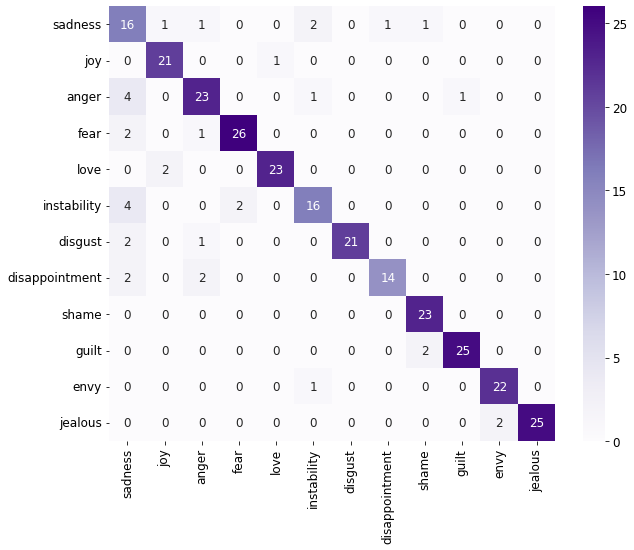

In [ ]:
#plot confusion matrix

cm = confusion_matrix(true_y, pred_y, labels=range(len(labels)))
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.rcParams.update({'font.size': 12}) 
plt.figure(figsize = (10,8));
sn.heatmap(df_cm, annot=True, cmap='Purples', fmt='g');

In [ ]:
module.save_model()